In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns
import anndata
import scanpy as sc
import re
import decoupler as dc
import sc_toolbox
import random
import seaborn.objects as so

In [2]:
data_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/"
newdata_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/"
plot_dir = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/"

sys.path = sys.path + ["/well/immune-rep/users/vbw431/python_utils/"]

In [3]:
import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging
import rpy2.robjects.lib.ggplot2 as gp
from rpy2.robjects import pandas2ri
from rpy2.robjects import r
from rpy2.ipython.ggplot import image_png

#sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/lib/python3.8/site-packages/rpy2/robjects/lib/ggplot2.py:70: UserWarning: This was designed againt ggplot2 versions starting with 3.3. but you have 3.4.2
  warnings.warn(


In [4]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/conda/ivybridge/envs/scverse_new/r_modules"), .libPaths()))

library(tidyverse)
library(parallel)
library(Seurat)
library(scater)


cur.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/data/DIMITRA_FASTQ/"
work.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/"
out.dir = "/well/immune-rep/users/vbw431/Projects/Peppa/out/"
references = "/well/immune-rep/users/vbw431/reference/reference/refdata-gex-GRCh38-2020-A/"
com.out = "/well/immune-rep/users/vbw431/Projects/Peppa/reference_combat/"

##plotting
library(ggplot2); theme_set(theme_bw(base_size = 18)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))



-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v lubridate 1.9.2     v tibble    3.2.1
v purrr     1.0.1     v tidyr     1.3.0
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x purrr::%@%()                 masks rlang::%@%()
x lazyeval::as_name()          masks rlang::as_name()
x lazyeval::call_modify()      masks rlang::call_modify()
x lazyeval::call_standardise() masks rlang::call_standardise()
x lazyeval::expr_label()       masks rlang::expr_label()
x lazyeval::expr_text()        masks rlang::expr_text()
x lazyeval::f_env()            masks rlang::f_env()
x lazyeval::f_env<-()          masks rlang::f_env<-()
x lazyeval::f_label()          masks rlang::f_label()
x lazyeval::f_lhs()            masks rlang::f_lhs()
x lazyeval::f_lhs<-()          masks rlang::f_lhs<-()
x lazyeval::f_rhs()            masks rlang::f_rhs()
x lazyeval::f_rhs<-() 

## Load Seurat data and Prepare for DGE

In [6]:
%%R 

##load, normalise  and trim to remove pre_treatment replicates and post vaccine samples from azimuth

peppa <- readRDS(paste0(out.dir, "/peppa_pbmc_all.rds"))




In [7]:
%%R
peppa <- subset(peppa, subset = celltype_consensus.l1 == "NK")



In [9]:
%%R 
##filter pre vaccination samples and pre treatment samples out
peppa <- subset(peppa, subset = Treatment_status != "Pre_treatment")

trim_barcodes <- peppa@meta.data %>% 
  dplyr::select(orig.ident) %>%
  dplyr::filter(grepl("_0|SeuratProject", orig.ident))
table(trim_barcodes)

peppa <- subset(peppa, cells = rownames(trim_barcodes))


In [10]:
%%R
##Normalise data
peppa <- peppa %>%
  NormalizeData() %>%
  ScaleData()


In [11]:
%%R
##remove previously identified ambient genes
genes.use <- grep(pattern = "^TRAC|^TRAV|^TRB|^TRGC|^TRGV",
                  rownames(peppa),
                  value=TRUE, invert=TRUE) 

## Run DEG on all NKs

In [12]:
%%R

contrasts <- c("CTRLvsHBV", "CTRLvsHBV_HIV", "HBVvsHBV_HIV")
dge_list = list()

for (i in 1:length(contrasts)){
    contrast <- as.list(unlist(strsplit(contrasts[[i]], "vs")))
    Idents(peppa) <- "study_disease"
    print(paste0("finding DGE across ", contrast[[1]], " and ", contrast[[2]], " for NK cells"))
    markers <- FindMarkers(peppa, only.pos = FALSE, features = genes.use, logfc.threshold = -Inf, min.pct = -Inf, ident.1 = contrast[[1]], ident.2 = contrast[[2]], method="DESeq2")
    markers$gene<-row.names(markers)
    markers$annotation <- "NK"
    dge_list[[paste0(contrasts[[i]])]] <- markers
}



[1] "finding DGE across CTRL and HBV for NK cells"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~25m 58s      

Error in select(., orig.ident) : could not find function "select"


RInterpreterError: Failed to parse and evaluate line '\ncontrasts <- c("CTRLvsHBV", "CTRLvsHBV_HIV", "HBVvsHBV_HIV")\ndge_list = list()\n\nfor (i in 1:length(contrasts)){\n    contrast <- as.list(unlist(strsplit(contrasts[[i]], "vs")))\n    Idents(peppa) <- "study_disease"\n    print(paste0("finding DGE across ", contrast[[1]], " and ", contrast[[2]], " for NK cells"))\n    markers <- FindMarkers(peppa, only.pos = FALSE, features = genes.use, logfc.threshold = -Inf, min.pct = -Inf, ident.1 = contrast[[1]], ident.2 = contrast[[2]], method="DESeq2")\n    markers$gene<-row.names(markers)\n    markers$annotation <- "NK"\n    dge_list[[paste0(contrasts[[i]])]] <- markers\n}\n\n'.
R error message: 'Error in select(., orig.ident) : could not find function "select"'

In [5]:
%%R

dge_list <- readRDS(paste0(out.dir, "/deg_list_NK.rds"))
print(names(dge_list))



[1] "CTRLvsHBV"     "CTRLvsHBV_HIV" "HBVvsHBV_HIV" 


In [10]:
%%R
print(names(dge_list))


[1] "CTRLvsHBV"     "CTRLvsHBV_HIV" "HBVvsHBV_HIV" 


In [6]:
%%R
merge_degs <- lapply(names(dge_list), function(x){
    dge_list[[x]] = dge_list[[x]]%>% filter(p_val_adj < 0.05)
    dge_list[[x]]$contrast = x
    return(dge_list[[x]])
})


In [7]:
%%R
merge_degs <- data.table::rbindlist(merge_degs)


`summarise()` has grouped output by 'annotation'. You can override using the
`.groups` argument.


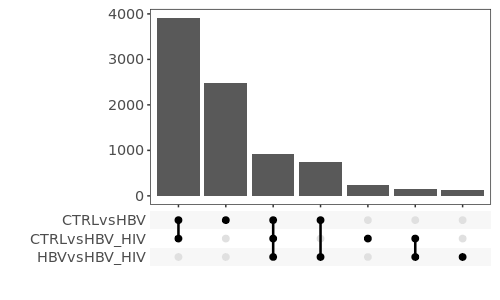

In [9]:
%%R -h 300 -w 500

library(ggupset)
NK_degs <- merge_degs %>% filter(p_val_adj < 0.05)


upsetplot_NK <- NK_degs %>%
  group_by(annotation, gene) %>%
  summarize(contrast = list(contrast))%>%
ggplot(aes(contrast))+
geom_bar()+
scale_x_upset()+
xlab("")+
ylab("")

print(upsetplot_NK)


In [13]:
%%R
#saveRDS(dge_list, paste0(out.dir, "/deg_list_NK.rds"))

NULL


In [13]:
%%R
DEG_list_NK

$CTRLvsHBV
                        p_val    avg_log2FC pct.1 pct.2     p_val_adj
ACTB             0.000000e+00 -4.582827e-01 0.999 0.998  0.000000e+00
ACTG1            0.000000e+00 -4.570469e-01 0.896 0.923  0.000000e+00
AES              0.000000e+00  2.246308e+00 0.508 0.000  0.000000e+00
B2M              0.000000e+00 -2.024133e-01 1.000 1.000  0.000000e+00
C19orf66         0.000000e+00  7.633030e-01 0.164 0.000  0.000000e+00
C19orf70         0.000000e+00  9.369561e-01 0.213 0.000  0.000000e+00
C1orf56          0.000000e+00  1.384889e+00 0.346 0.013  0.000000e+00
C6orf48          0.000000e+00  9.314254e-01 0.207 0.000  0.000000e+00
C8orf59          0.000000e+00  1.174447e+00 0.268 0.000  0.000000e+00
CALM1            0.000000e+00 -2.081734e-01 0.984 0.962  0.000000e+00
CD7              0.000000e+00 -6.040028e-01 0.823 0.867  0.000000e+00
CFL1             0.000000e+00 -3.326667e-01 0.981 0.963  0.000000e+00
CLIC1            0.000000e+00 -4.343490e-01 0.793 0.799  0.000000e+00
CORO1A   

TAF1D           1.219787e-164  5.361099e-01 0.393 0.146 2.901751e-160
NDUFA5          1.712441e-164  5.099889e-01 0.325 0.106 4.073727e-160
CMIP            2.607137e-164  5.540123e-01 0.224 0.056 6.202118e-160
G0S2            1.159470e-163  4.869837e-01 0.111 0.007 2.758262e-159
DYNC1I2         1.672580e-163  5.016414e-01 0.205 0.046 3.978901e-159
ATP5MC2         4.051411e-162 -2.820958e-01 0.838 0.761 9.637902e-158
NME2            5.935708e-162 -7.394575e-01 0.308 0.517 1.412046e-157
PKN2            3.299016e-160  5.360460e-01 0.282 0.087 7.848030e-156
MED13           4.606816e-160  5.031733e-01 0.202 0.046 1.095915e-155
PTP4A1          6.094080e-160  4.175095e-01 0.089 0.001 1.449721e-155
CEBPZ           1.788652e-159  5.261556e-01 0.353 0.126 4.255024e-155
ESCO1           8.325166e-159  5.266548e-01 0.265 0.078 1.980474e-154
TUT4            1.442580e-158  5.230378e-01 0.405 0.155 3.431754e-154
AC239800.3      1.705476e-158  4.263726e-01 0.085 0.000 4.057157e-154
AKAP9           5.40

SETD2           9.920741e-105  3.823095e-01 0.347 0.151 2.360045e-100
TCEAL8          1.182596e-104  3.765217e-01 0.177 0.053 2.813278e-100
EIF3G           1.725821e-104 -3.757205e-01 0.678 0.636 4.105556e-100
CEMIP2          2.005851e-104  4.236366e-01 0.334 0.145 4.771719e-100
MECP2           3.576208e-104  3.674056e-01 0.289 0.116 8.507442e-100
AC058791.1      1.450846e-103  3.352198e-01 0.083 0.009  3.451418e-99
GCC2            1.588430e-103  3.907871e-01 0.455 0.216  3.778716e-99
RPL9            2.342160e-103  2.527460e-01 0.975 0.826  5.571764e-99
SLU7            2.565747e-103  3.680056e-01 0.273 0.107  6.103657e-99
RAB11FIP1       2.731370e-103  3.611534e-01 0.285 0.114  6.497656e-99
FAM215B         6.414941e-103  3.039664e-01 0.069 0.004  1.526050e-98
SOS1            9.839465e-103  3.367700e-01 0.161 0.045  2.340710e-98
IK              1.078383e-102  3.863434e-01 0.503 0.243  2.565365e-98
STXBP3          1.080510e-102  3.602568e-01 0.177 0.054  2.570426e-98
KPNA6           1.21

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  1.639223e-86  3.245773e-01 0.200 0.074  3.899547e-82
GTPBP4           3.325191e-86  3.586989e-01 0.181 0.064  7.910298e-82
PNISR            4.395507e-86  3.997939e-01 0.736 0.420  1.045647e-81
LINC00623        4.482193e-86  2.639395e-01 0.243 0.097  1.066269e-81
PPP6R2           1.095925e-85  3.086909e-01 0.210 0.080  2.607097e-81
ARID2            1.116921e-85  3.074641e-01 0.180 0.062  2.657043e-81
NAMPT            1.278045e-85  3.287038e-01 0.121 0.031  3.040342e-81
MT-CYB           1.407414e-85 -1.029150e-01 0.998 0.990  3.348097e-81
EZH1             1.498336e-85  3.249132e-01 0.168 0.056  3.564392e-81
COMMD2           1.530766e-85  3.507311e-01 0.252 0.105  3.641539e-81
RPS16            1.629039e-85 -8.990843e-02 0.989 0.952  3.875322e-81
UTRN             1.988515e-85  4.026162e-01 0.704 0.398  4.730478e-81
MBD4             2.659445e-85  3.187807e-01 0.312 0.141  6.326554e-81
AC005332.5       3.333248e-85  2.656815e-01 0.066 0.006  7.929464e-81
KIAA0355         3.486413e-85  3.09

SCAPER           2.831875e-71  2.614893e-01 0.155 0.055  6.736747e-67
MARK3            4.398489e-71  2.706261e-01 0.261 0.120  1.046356e-66
AC073111.5       5.953732e-71  1.960016e-01 0.038 0.000  1.416333e-66
HLA-DQB1         6.111512e-71  3.841112e-01 0.161 0.061  1.453867e-66
LTB              6.502077e-71  2.172598e-01 0.307 0.147  1.546779e-66
PRDM1            6.695752e-71  2.907504e-01 0.418 0.215  1.592852e-66
PHF14            6.991133e-71  2.357773e-01 0.217 0.091  1.663121e-66
HSPA14.1         6.999504e-71  2.809847e-01 0.080 0.016  1.665112e-66
GIGYF2           7.661696e-71  2.669297e-01 0.171 0.065  1.822641e-66
ZNF638           8.499319e-71  2.495536e-01 0.273 0.126  2.021903e-66
ZC3H15           1.008097e-70  2.843747e-01 0.455 0.238  2.398162e-66
NDUFS5           1.181536e-70  3.049374e-01 0.572 0.309  2.810755e-66
ARID1A           1.199108e-70  2.325781e-01 0.301 0.142  2.852558e-66
DEGS2            1.220005e-70  1.969151e-01 0.041 0.001  2.902270e-66
CDK5RAP2         1.2

ERROR : subscript out of bounds 


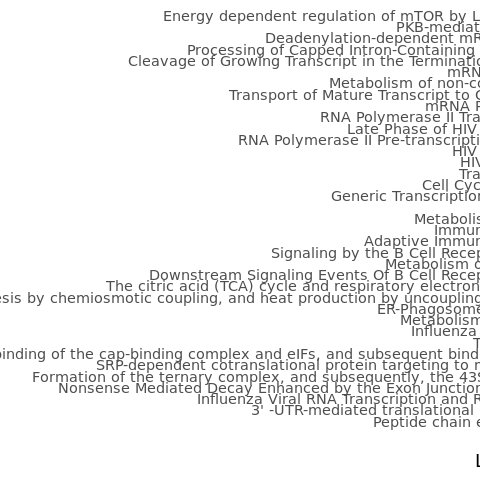

In [7]:
%%R
## Perform XGR enrichment on HBV vs HBV_HIV
library(tidyverse)
library(XGR)
DEG_list_NK <- dge_list

categories <- c("HBVvsHBV_HIV")

#Here we select the same number of significant DEGs for big v small
n_pos<-vector('double', length(categories))
n_neg<-vector('double', length(categories))
n<-vector('double', length(categories))
for(i in 1:length(categories)){
  n_pos[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC>0)))
  n_neg[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC<0)))
  n[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05)))
}
min(n)
#And use these as input to the GOBP analysis 
sig_gene_induced<-list()
sig_gene_suppressed<-list()
summary_df<-list()
for(i in 1:length(categories)){
  summary_df[[i]]<-DEG_list_NK[[i]]
  summary_df[[i]]<-as.data.frame(summary_df[[i]])
  summary_df[[i]]$log10p <- -log10(summary_df[[i]]$p_val_adj)
  summary_df[[i]]$sig <- ifelse(summary_df[[i]]$p_val_adj > 0.049 | summary_df[[i]]$p_val_adj %in% NA, "no", "sig")
  summary_df[[i]]$change <- case_when(summary_df[[i]]$avg_log2FC > 0 & summary_df[[i]]$sig == "sig" ~ "Induced", 
                                      summary_df[[i]]$avg_log2FC < 0 & summary_df[[i]]$sig == "sig" ~ "Suppressed",
                                      summary_df[[i]]$sig %in% "no" ~ "None")
  summary_df[[i]]$x <- summary_df[[i]][,'avg_log2FC']
  summary_df[[i]]$y <- summary_df[[i]][,'log10p']
  summary_df[[i]]$colour <- summary_df[[i]][,'change']
  sig_gene_induced[[i]]<-summary_df[[i]] %>% filter(change == 'Induced') %>% arrange(-avg_log2FC) %>% head(n=min(n_pos))
  sig_gene_suppressed[[i]]<-summary_df[[i]] %>% filter(change == 'Suppressed') %>% arrange(avg_log2FC) %>% head(n=min(n_neg))
  summary_df[[i]]$label_2 <- ifelse(summary_df[[i]]$gene %in% c(sig_gene_induced[[i]]$gene, sig_gene_suppressed[[i]]$gene), paste(summary_df[[i]]$gene), paste(''))
}
head(sig_gene_suppressed[[i]])
head(summary_df[[i]])
#Run the GOBP here

REACTOME_list<-list()
for(i in 1:2){
  tryCatch({
    background <- as.character(DEG_list_NK[[i]]$gene)
    induced <- sig_gene_induced[[i]]$gene
    suppressed <- sig_gene_suppressed[[i]]$gene
    
    List <- list(induced, suppressed)
    Condition <- list("overexpressed", "suppressed")
    Output <- vector(mode = "list", length = length(List))
    
    ontology = "MsigdbC2REACTOME" # alternative is ontology = "REACTOME" or something like that
    for(j in seq_along(List)) {
      tryCatch({
        Output[[j]] <- xEnricherGenes(data = List[[j]], background = background, ontology = ontology,
                                      test = "hypergeo", min.overlap = 2)
        #Output[[j]] <- xEnrichConciser(Output[[j]])
        Output[[j]] <- xEnrichViewer(Output[[j]], top_num = 20)
        Output[[j]]$direction <- Condition[[j]]
      }, error=function(e){cat("ERROR :",conditionMessage(e), "\n")})
    }
    
    REACTOME <- rbind(Output[[1]], Output[[2]])
    REACTOME <- data.frame(REACTOME)
    REACTOME$fc <-
      ifelse(REACTOME$direction %in% "suppressed",
             REACTOME$fc * (-1),
             REACTOME$fc)
    REACTOME$REACTOME <- row.names(REACTOME)
    REACTOME$REACTOME <-
      factor(REACTOME$REACTOME, levels = c(row.names(REACTOME[order(REACTOME$fc), ])))
    REACTOME <- REACTOME[REACTOME$adjp < 0.0501, ]
    REACTOME$label_adj <- case_when(REACTOME$direction %in% "overexpressed" ~ -1,
                                REACTOME$direction %in% "suppressed" ~ 1)
    
    REACTOME$category<-categories[i]
    REACTOME_list[[i]]<-REACTOME
    
  }, error=function(e){cat("ERROR :",conditionMessage(e), "\n")})
} 


REACTOME<-plyr::ldply(REACTOME_list, rbind) 


#NOW WE DO BIG V SMALL EC BALLPLOT
#Here we just have to modify the REACTOME number for the duplicated pathways as those with duplicates are given a suffix of '1' by XGR

duplicated_pathways<-as.character(unlist(REACTOME %>% group_by(category) %>% add_count(name) %>% dplyr::filter(n>1) %>% ungroup() %>% dplyr::select(name) %>% unique()))
REACTOME<-REACTOME %>%  group_by(category, name) %>% dplyr::slice(which.max(nOverlap)) %>% ungroup()
REACTOME$REACTOME<-ifelse(REACTOME$category=='HBV_HIV' & REACTOME$name %in% duplicated_pathways, str_sub(REACTOME$REACTOME, end=-2), paste(REACTOME$REACTOME))

#And modify to create a log scale, remove duplicates and colour the text in line with the data     
REACTOME$pos_FC<-sqrt(REACTOME$fc^2)
REACTOME$pos_log10FC<-log10(REACTOME$pos_FC)
REACTOME$log10FC<-ifelse(REACTOME$fc<0, REACTOME$pos_log10FC*-1, REACTOME$pos_log10FC)
#REACTOME$category<-factor(REACTOME$category, levels = c('Adaptive NK', 'Mature NK'))

REACTOME[grepl("GSE41867", REACTOME$REACTOME),]

margin_spacer <- function(x) {
  # where x is the column in your dataset
  left_length <- nchar(levels(factor(x)))[1]
  if (left_length > 8) {
    return((left_length - 8) * 4)
  }
  else
    return(0)
}

ballplot <- REACTOME %>% 
  filter(nOverlap >=2)%>%
ggplot()+
  geom_point(aes(x=reorder(name, fc), y=log10FC, size=-log10(pvalue), alpha=nOverlap, colour=category))+
   scale_size(range=c(5,10))+
    guides(color = guide_legend(override.aes = list(size=6)), alpha = guide_legend(override.aes = list(size=6)))+
    labs(colour='NK cluster', alpha='No. of genes in pathway')+
  ggsci::scale_color_d3() +
  scale_alpha_continuous(n.breaks=4,range = c(0.4, 1))+
  coord_flip()+
  xlab('REACTOME')+
  ylab('Log10 Fold Change')+
  geom_hline(yintercept = 0)+
  theme_bw(base_size=18)

print(ballplot)

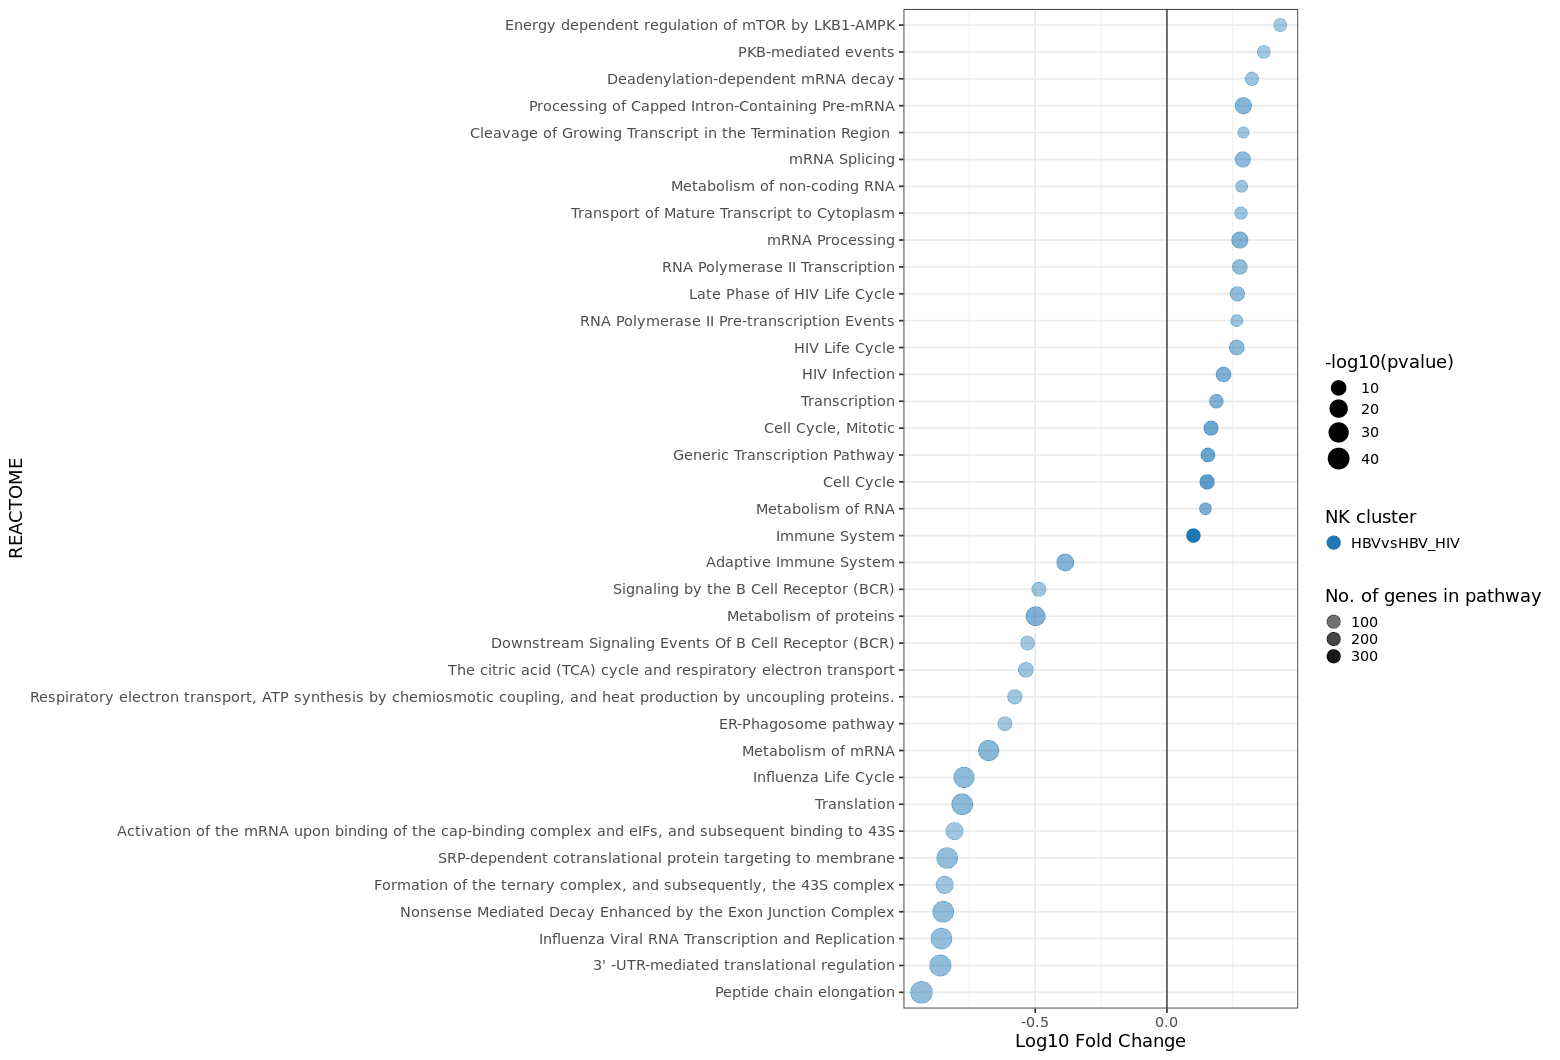

In [13]:
%%R -w 1560 -h 1060


print(ballplot)


In [14]:
%%R 
REACTOME

# A tibble: 37 x 17
   name         nAnno nOverlap    fc zscore   pvalue     adjp    or   CIl    CIu
   <chr>        <dbl>    <dbl> <dbl>  <dbl>    <dbl>    <dbl> <dbl> <dbl>  <dbl>
 1 "3' -UTR-me~   104       63 -7.24  19.3  1.10e-42 2.60e-40 17.5  11.6  2.68e1
 2 "Activation~    56       30 -6.4   12.2  2.10e-19 8.10e-18 12.9   7.34 2.28e1
 3 "Adaptive I~   497      101 -2.43   9.77 7.4 e-18 2.70e-16  2.93  2.31 3.68e0
 4 "Cell Cycle"   394      194  1.42   6.16 6.40e-10 4.6 e- 8  1.86  1.51 2.28e0
 5 "Cell Cycle~   307      156  1.47   6.01 1.6 e- 9 1   e- 7  1.97  1.56 2.49e0
 6 "Cleavage o~    43       29  1.95   4.52 2.8 e- 6 8   e- 5  3.92  2    8.04e0
 7 "Deadenylat~    44       32  2.1    5.32 5.3 e- 8 2.3 e- 6  5.05  2.53 1.08e1
 8 "Downstream~    92       26 -3.38   6.91 4.20e- 9 9.9 e- 8  4.38  2.66 7.01e0
 9 "ER-Phagoso~    58       20 -4.12   7.2  3.30e- 9 8.3 e- 8  5.83  3.21 1.03e1
10 "Energy dep~    15       14  2.69   4.78 1.20e- 7 5.10e- 6 26.5   4.02 1.11e3
# i 27 m

In [19]:
%%R
ggsave(ballplot, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/ballplot_allNK.eps", device="eps",  width = 6, height = 3, units = "in")


In [14]:
%%R
ggsave(upsetplot_NK, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/upset_NK.eps", device="eps",  width = 6, height = 3, units = "in")


## Volcano plot of shared DEGs in infected individuals

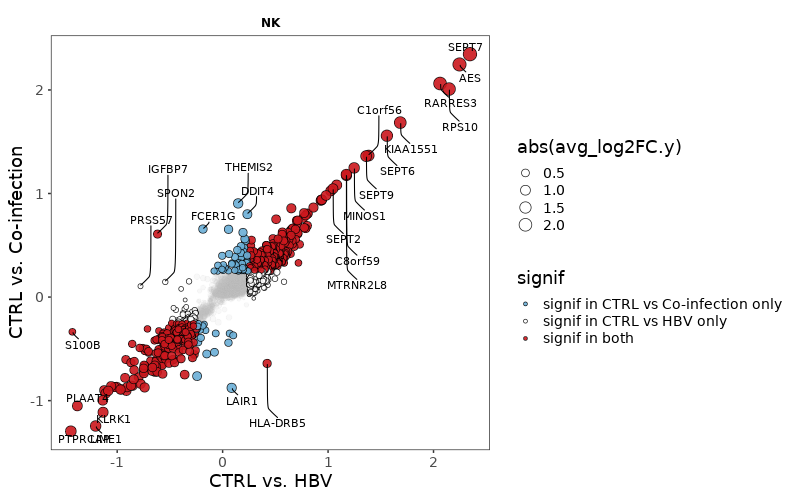

In [15]:
%%R -h 500 -w 800
CTRL_degs <- merge_degs %>%
filter(grepl("CTRL", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, gene, NA))


CTRL_degs <- split(CTRL_degs, CTRL_degs$contrast)
cross_df <- CTRL_degs[["CTRLvsHBV"]] %>%
full_join(CTRL_degs[["CTRLvsHBV_HIV"]], by=c("gene", "annotation")) %>%
mutate(signif = ifelse(signif.x == "signif" & is.na(signif.y), "signif in CTRL vs HBV only",
                            ifelse(is.na(signif.x) & signif.y == "signif", "signif in CTRL vs Co-infection only", 
                                  ifelse(signif.x == "signif" & signif.y == "signif", "signif in both",NULL)))) %>%
mutate(labels = ifelse(signif.x == "signif" & is.na(signif.y), gene,
                            ifelse(is.na(signif.x) & signif.y == "signif", gene, 
                                  ifelse(signif.x == "signif" & signif.y == "signif", gene,NA))))  

bivolplot <- cross_df %>%
ggplot(aes(avg_log2FC.x, avg_log2FC.y))+
geom_point(aes(size = abs(avg_log2FC.y)),color = "gray", alpha=0.1)+
geom_point(data = cross_df %>% filter(!is.na(signif)),aes(size = abs(avg_log2FC.y)), color="white")+
geom_point(data = cross_df %>% filter(!is.na(signif)), aes(fill = signif, size = abs(avg_log2FC.y)), shape = 21, color= "black", alpha=0.9)+
facet_wrap(~annotation)+
ggrepel::geom_text_repel(aes(label = labels),
                         nudge_x = .1,
    box.padding = 0.5,
    nudge_y = -0.1,
    segment.curvature = -0.1,
    segment.ncp = 4,
    segment.angle = 20,
    direction = "y",
    max.time = 5, 
    max.iter = 100000,
    force=10,
    force_pull=1,
    max.overlaps=15)+
scale_fill_manual(values = c("#6baed6","#ffffff","#cb181d"))+
xlab("CTRL vs. HBV")+
ylab("CTRL vs. Co-infection")


bivolplot


In [16]:
%%R
ggsave(bivolplot, file="/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_bivolplot.pdf", device="pdf",  width = 11, height = 7, units = "in")


In [17]:
%%R
.libPaths(c(paste0("/well/immune-rep/users/vbw431/python/test_immcantation-skylake/r_modules"), .libPaths()))
library(XGR)

In [62]:
%%R
#.libPaths(c(paste0("/well/immune-rep/users/vbw431/python/test_immcantation-skylake/r_modules"), .libPaths()))
library(XGR)

enrichdfdown = merge_degs %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0, gene, NA))%>% 
filter(!is.na(signif)) %>% 
filter(avg_log2FC <0)

enrichdfdown_list = split(enrichdfdown, enrichdfdown$contrast)

enrich_infection <- lapply(names(enrichdfdown_list), function(x){
    data <- enrichdfdown_list[[x]]$gene
    ontology = "MsigdbC2BIOCARTA"
    #ontology = "GOBP",
    eTerm <- xEnricherGenes(data=data, ontology=ontology, test = "hypergeo",min.overlap = 2)
    eTerm_im <- xEnrichConciser(eTerm)
    df <- xEnrichViewer(eTerm_im, 10, details = T)
return(df)
})


In [63]:
%%R
names(enrich_infection) <- names(enrichdfdown_list)
enrich_infection = lapply(names(enrich_infection), function(x){
    enrich_infection[[x]]$contrast <- x
    return(enrich_infection[[x]])
})
head(enrich_infection[[1]])
enrich_infection <- data.table::rbindlist(enrich_infection)


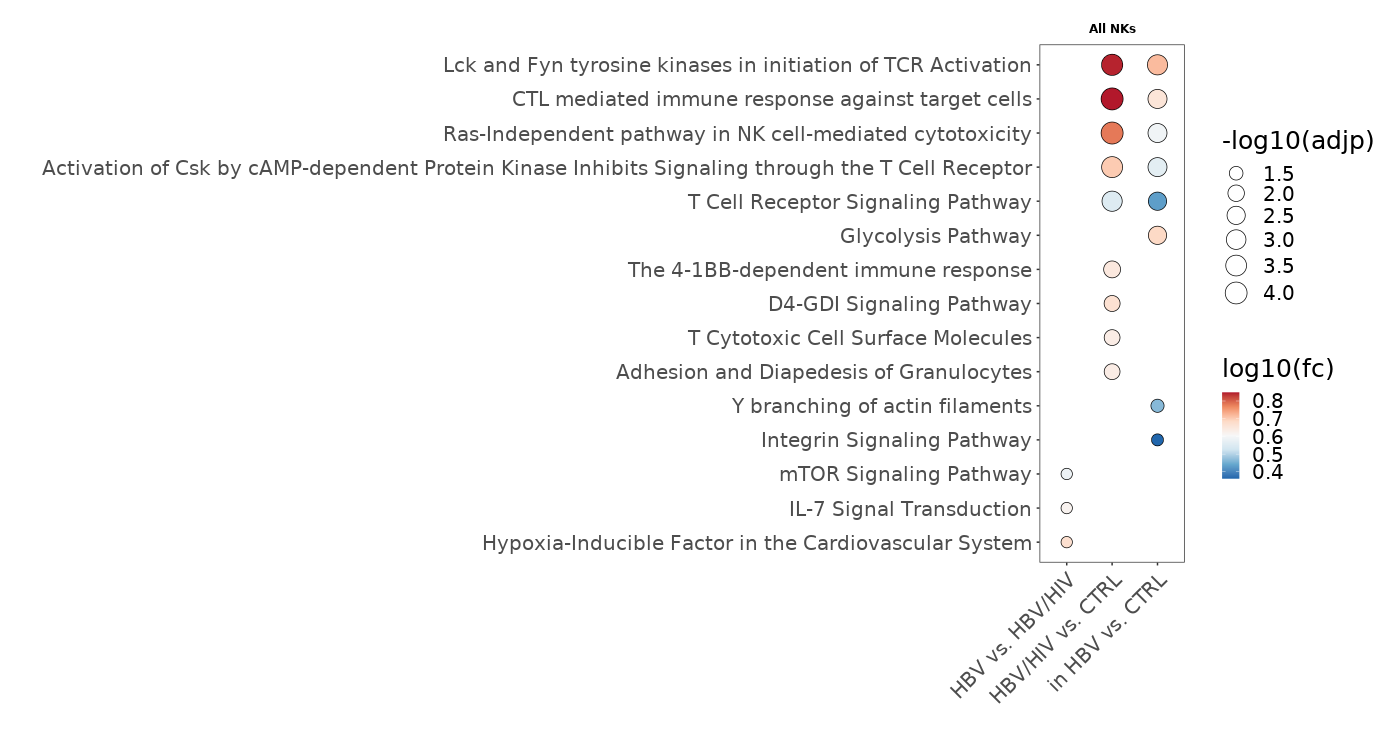

In [89]:
%%R -w 1400 -h 750
library(RColorBrewer)
NK_enrich <- enrich_infection %>%
mutate(contrast = ifelse(grepl("vsHBV$", contrast), "in HBV vs. CTRL",
      ifelse(grepl("CTRLvsHBV_HIV", contrast), "HBV/HIV vs. CTRL",
            ifelse(grepl("HBVvsHBV_HIV", contrast), "HBV vs. HBV/HIV", NA))))  %>%
filter(adjp <0.05) %>%
filter(nOverlap >=2) %>%
mutate(category = "All NKs") %>%
filter(!grepl("Nuclear receptors|Eukaryotic|IL12 and|Skeletal|CTCF|eIFe|Rho", name))%>% ## trim non interesting pathways for simplicity of figure
ggplot(aes(contrast, reorder(name, -log10(adjp))))+
geom_point(aes(fill = log10(fc), size = -log10(adjp)), shape = 21)+
scale_fill_distiller(palette = "RdBu")+
#viridis::scale_fill_viridis()+
theme(axis.text.x = element_text(angle=45, hjust =1))+
scale_size(range = c(5, 10))+
facet_wrap(~category)+
xlab("")+
ylab("")
NK_enrich

In [65]:
%%R

pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_enrich.pdf",width = 12,height = 7)
plot(NK_enrich)
dev.off()

[1] 2


## Subset DEGs

In [22]:
%%R
peppa_list <- SplitObject(peppa,split.by="celltype_consensus.l2")
names(peppa_list)

[1] "NK.Adaptive.CCL4.CCL3" "NK.Adaptive"           "NK.Mature"            
[4] "NK.CD56bright"         "NK.Prolifering"       


In [23]:
%%R

contrasts <- c("CTRLvsHBV", "CTRLvsHBV_HIV", "HBVvsHBV_HIV")
dge_list = list()

for (i in 1:length(contrasts)){
    contrast <- as.list(unlist(strsplit(contrasts[[i]], "vs")))
    markers <- lapply(names(peppa_list), function(x){
        Idents(peppa_list[[x]]) <- "study_disease"
        print(paste0("finding DGE across ", contrast[[1]], " and ", contrast[[2]], " for ", x))
        markers <- FindMarkers(peppa_list[[x]], only.pos = FALSE, features = genes.use, logfc.threshold = -Inf, min.pct = -Inf, ident.1 = contrast[[1]], ident.2 = contrast[[2]], method="DESeq2")
        markers$gene<-row.names(markers)
        markers$annotation <- paste0(x)
        return(markers)
    })
    names(markers) <- names(peppa_list)
    dge_list[[paste0(contrasts[[i]])]] <- markers
}



[1] "finding DGE across CTRL and HBV for NK.Adaptive.CCL4.CCL3"
  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02m 11s       |+                                                 | 2 % ~02m 03s       |++                                                | 3 % ~02m 00s       |++                                                | 4 % ~01m 58s       |+++                                               | 5 % ~01m 56s       |+++                                               | 6 % ~01m 55s       |++++                                              | 7 % ~01m 58s       |++++                                              | 8 % ~01m 57s       |+++++                                             | 9 % ~01m 54s       |+++++                                             | 10% ~01m 52s       |++++++                                            | 11% ~01m 50s       |++++++                                            | 12% ~01m 48s     

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10m 51s       |+                                                 | 2 % ~10m 29s       |++                                                | 3 % ~10m 28s       |++                                                | 4 % ~10m 24s       |+++                                               | 5 % ~10m 11s       |+++                                               | 6 % ~10m 07s       |++++                                              | 7 % ~10m 01s       |++++                                              | 8 % ~09m 57s       |+++++                                             | 9 % ~09m 51s       |+++++                                             | 10% ~09m 43s       |++++++                                            | 11% ~09m 35s       |++++++                                            | 12% ~09m 29s       |+++++++                                           | 13% ~09m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01m 11s       |+                                                 | 2 % ~01m 09s       |++                                                | 3 % ~01m 07s       |++                                                | 4 % ~01m 09s       |+++                                               | 5 % ~01m 06s       |+++                                               | 6 % ~01m 05s       |++++                                              | 7 % ~01m 03s       |++++                                              | 8 % ~01m 02s       |+++++                                             | 9 % ~01m 02s       |+++++                                             | 10% ~01m 01s       |++++++                                            | 11% ~01m 02s       |++++++                                            | 12% ~01m 02s       |+++++++                                           | 13% ~01m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~10m 21s       |+                                                 | 2 % ~10m 06s       |++                                                | 3 % ~10m 04s       |++                                                | 4 % ~10m 04s       |+++                                               | 5 % ~09m 58s       |+++                                               | 6 % ~09m 57s       |++++                                              | 7 % ~10m 00s       |++++                                              | 8 % ~09m 53s       |+++++                                             | 9 % ~09m 46s       |+++++                                             | 10% ~09m 38s       |++++++                                            | 11% ~09m 33s       |++++++                                            | 12% ~09m 26s       |+++++++                                           | 13% ~09m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~02m 22s       |+                                                 | 2 % ~02m 18s       |++                                                | 3 % ~02m 16s       |++                                                | 4 % ~02m 13s       |+++                                               | 5 % ~02m 11s       |+++                                               | 6 % ~02m 08s       |++++                                              | 7 % ~02m 05s       |++++                                              | 8 % ~02m 03s       |+++++                                             | 9 % ~02m 02s       |+++++                                             | 10% ~02m 06s       |++++++                                            | 11% ~02m 07s       |++++++                                            | 12% ~02m 05s       |+++++++                                           | 13% ~02m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~01m 59s       |+                                                 | 2 % ~01m 53s       |++                                                | 3 % ~01m 51s       |++                                                | 4 % ~01m 50s       |+++                                               | 5 % ~01m 47s       |+++                                               | 6 % ~01m 45s       |++++                                              | 7 % ~01m 44s       |++++                                              | 8 % ~01m 49s       |+++++                                             | 9 % ~01m 48s       |+++++                                             | 10% ~01m 47s       |++++++                                            | 11% ~01m 45s       |++++++                                            | 12% ~01m 44s       |+++++++                                           | 13% ~01m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~08m 28s       |+                                                 | 2 % ~07m 39s       |++                                                | 3 % ~07m 14s       |++                                                | 4 % ~07m 04s       |+++                                               | 5 % ~06m 52s       |+++                                               | 6 % ~06m 44s       |++++                                              | 7 % ~06m 36s       |++++                                              | 8 % ~06m 35s       |+++++                                             | 9 % ~06m 29s       |+++++                                             | 10% ~06m 30s       |++++++                                            | 11% ~06m 26s       |++++++                                            | 12% ~06m 22s       |+++++++                                           | 13% ~06m 

  |                                                  | 0 % ~calculating   |+                                                 | 1 % ~55s           |+                                                 | 2 % ~55s           |++                                                | 3 % ~54s           |++                                                | 4 % ~53s           |+++                                               | 5 % ~52s           |+++                                               | 6 % ~51s           |++++                                              | 7 % ~50s           |++++                                              | 8 % ~50s           |+++++                                             | 9 % ~49s           |+++++                                             | 10% ~50s           |++++++                                            | 11% ~49s           |++++++                                            | 12% ~50s           |+++++++                                           | 13% ~50s 

In [24]:
%%R
dge_list[["HBVvsHBV_HIV"]][["NK.Prolifering"]] <- NULL

In [25]:
%%R
##remove NK proliferating due to under representation of DEGs
length(dge_list[["HBVvsHBV_HIV"]])
names(dge_list[["HBVvsHBV_HIV"]])

[1] "NK.Adaptive.CCL4.CCL3" "NK.Adaptive"           "NK.Mature"            
[4] "NK.CD56bright"        


In [26]:
%%R
#Do DEG for large pre v post and small pre v post NK to generate list of DEGs
#saveRDS(dge_list, paste0(out.dir, "/deg_list_NK_subsets_iterated.rds"))
dge_list <- readRDS(paste0(out.dir, "/deg_list_NK_subsets_iterated.rds"))
DEG_list_NK <-dge_list[["HBVvsHBV_HIV"]]



## Examine number of DEGs


In [27]:
%%R
merge_degs <- lapply(names(dge_list), function(x){
    y <- data.table::rbindlist(dge_list[[x]])
    y$contrast = x
    return(y)
})

merge_degs <- data.table::rbindlist(merge_degs)
head(merge_degs)

           p_val avg_log2FC pct.1 pct.2     p_val_adj  gene
1: 3.708790e-111 -0.7537390 0.876 0.982 8.822840e-107 RPS26
2:  3.208975e-92 -0.3696773 0.998 0.998  7.633831e-88  ACTB
3:  4.886563e-88 -0.3136487 1.000 1.000  1.162464e-83  NKG7
4:  8.469212e-87 -0.5149387 0.941 0.977  2.014741e-82  CYBA
5:  7.903764e-80 -0.4362384 0.982 0.991  1.880226e-75  CST7
6:  2.597085e-77 -0.3605176 0.988 0.996  6.178204e-73  PFN1
              annotation  contrast
1: NK.Adaptive.CCL4.CCL3 CTRLvsHBV
2: NK.Adaptive.CCL4.CCL3 CTRLvsHBV
3: NK.Adaptive.CCL4.CCL3 CTRLvsHBV
4: NK.Adaptive.CCL4.CCL3 CTRLvsHBV
5: NK.Adaptive.CCL4.CCL3 CTRLvsHBV
6: NK.Adaptive.CCL4.CCL3 CTRLvsHBV


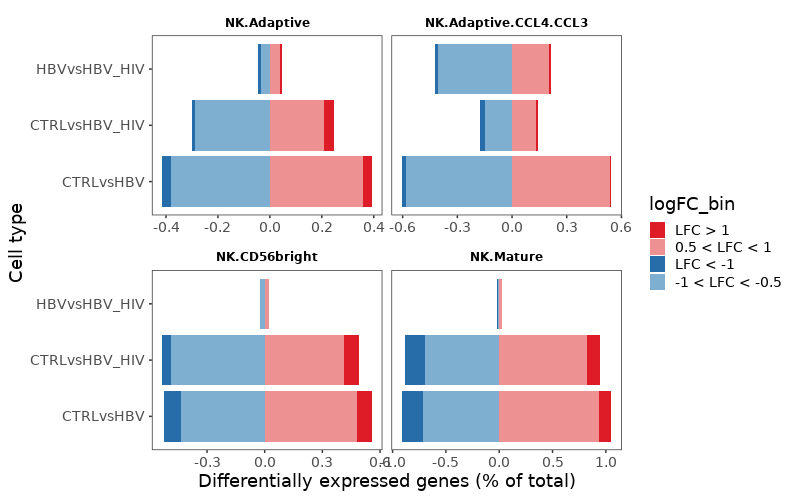

In [28]:
%%R -w 800 -h 500
prop_deg <- merge_degs %>%
#filter(p_val_adj < 0.05) %>%
filter(!grepl("Prolifering", annotation)) %>%
mutate(logFC_bin = ifelse(avg_log2FC > 1, "LFC > 1", 
                         ifelse(avg_log2FC <1 & avg_log2FC > 0.5, "0.5 < LFC < 1", 
                         ifelse(avg_log2FC < -1, "LFC < -1", 
                               ifelse(avg_log2FC > -1 & avg_log2FC < -0.5, "-1 < LFC < -0.5", NA))))) %>%
mutate(logFC_bin = factor(logFC_bin, levels = c("LFC > 1", "0.5 < LFC < 1", "LFC < -1", "-1 < LFC < -0.5"))) %>%
group_by(annotation, contrast) %>%
add_tally(name = "total") %>%
ungroup() %>%
group_by(annotation, contrast, logFC_bin, total) %>%
  tally(name="logFC_counts") %>%
  ungroup() %>%
filter(!is.na(logFC_bin)) %>%
mutate(percent_total = logFC_counts/total*100) %>%
mutate(percent_total=ifelse(grepl("-1", logFC_bin), percent_total*-1, percent_total)) %>%
ggplot(aes(percent_total, contrast))+
geom_col(aes(fill = logFC_bin), position = "stack")+
facet_wrap(~annotation, scales="free_x")+
ylab("Cell type")+
xlab("Differentially expressed genes (% of total)")+
scale_fill_manual(values = c("#DD1C28", "#EE9193", "#276DAA","#7EAED0"))
print(prop_deg)

`summarise()` has grouped output by 'annotation'. You can override using the `.groups` argument.


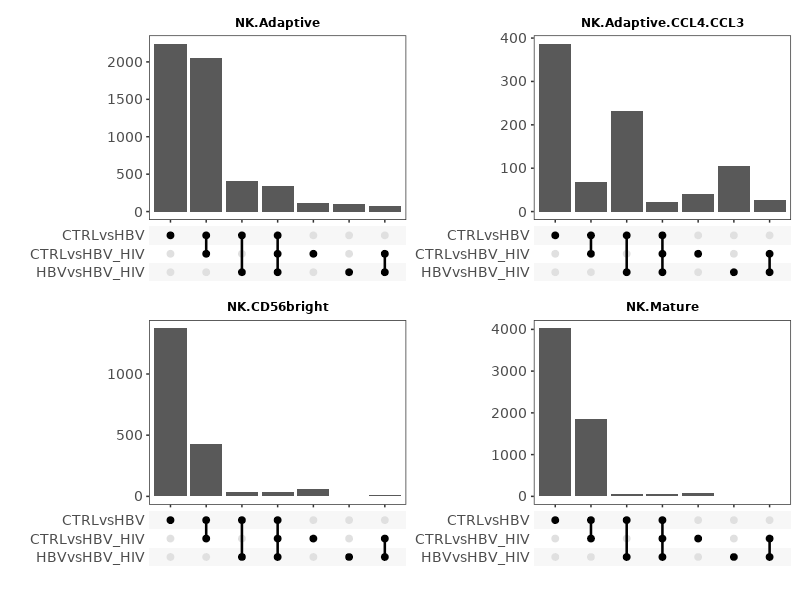

In [29]:
%%R -h 600 -w 800
library(ggupset)
NK_degs <- merge_degs %>% filter(p_val_adj < 0.05)%>%filter(!grepl("Prolifering", annotation))


upsetplots <- NK_degs %>%
  group_by(annotation, gene) %>%
  summarize(contrast = list(contrast))%>%
ggplot(aes(contrast))+
geom_bar()+
facet_wrap(~annotation, scales = "free")+
scale_x_upset()+
xlab("")+
ylab("")

print(upsetplots)



1.00s elapsed for 6480 iterations, 35 overlaps. Consider increasing 'max.time'.
text repel complete in 24022 iterations (0.47s), 6 overlaps
1.00s elapsed for 3430 iterations, 31 overlaps. Consider increasing 'max.time'.
1.00s elapsed for 14120 iterations, 35 overlaps. Consider increasing 'max.time'.
1.00s elapsed for 8030 iterations, 22 overlaps. Consider increasing 'max.time'.
text repel complete in 17594 iterations (0.24s), 7 overlaps
1.00s elapsed for 3810 iterations, 25 overlaps. Consider increasing 'max.time'.
1.00s elapsed for 14960 iterations, 27 overlaps. Consider increasing 'max.time'.


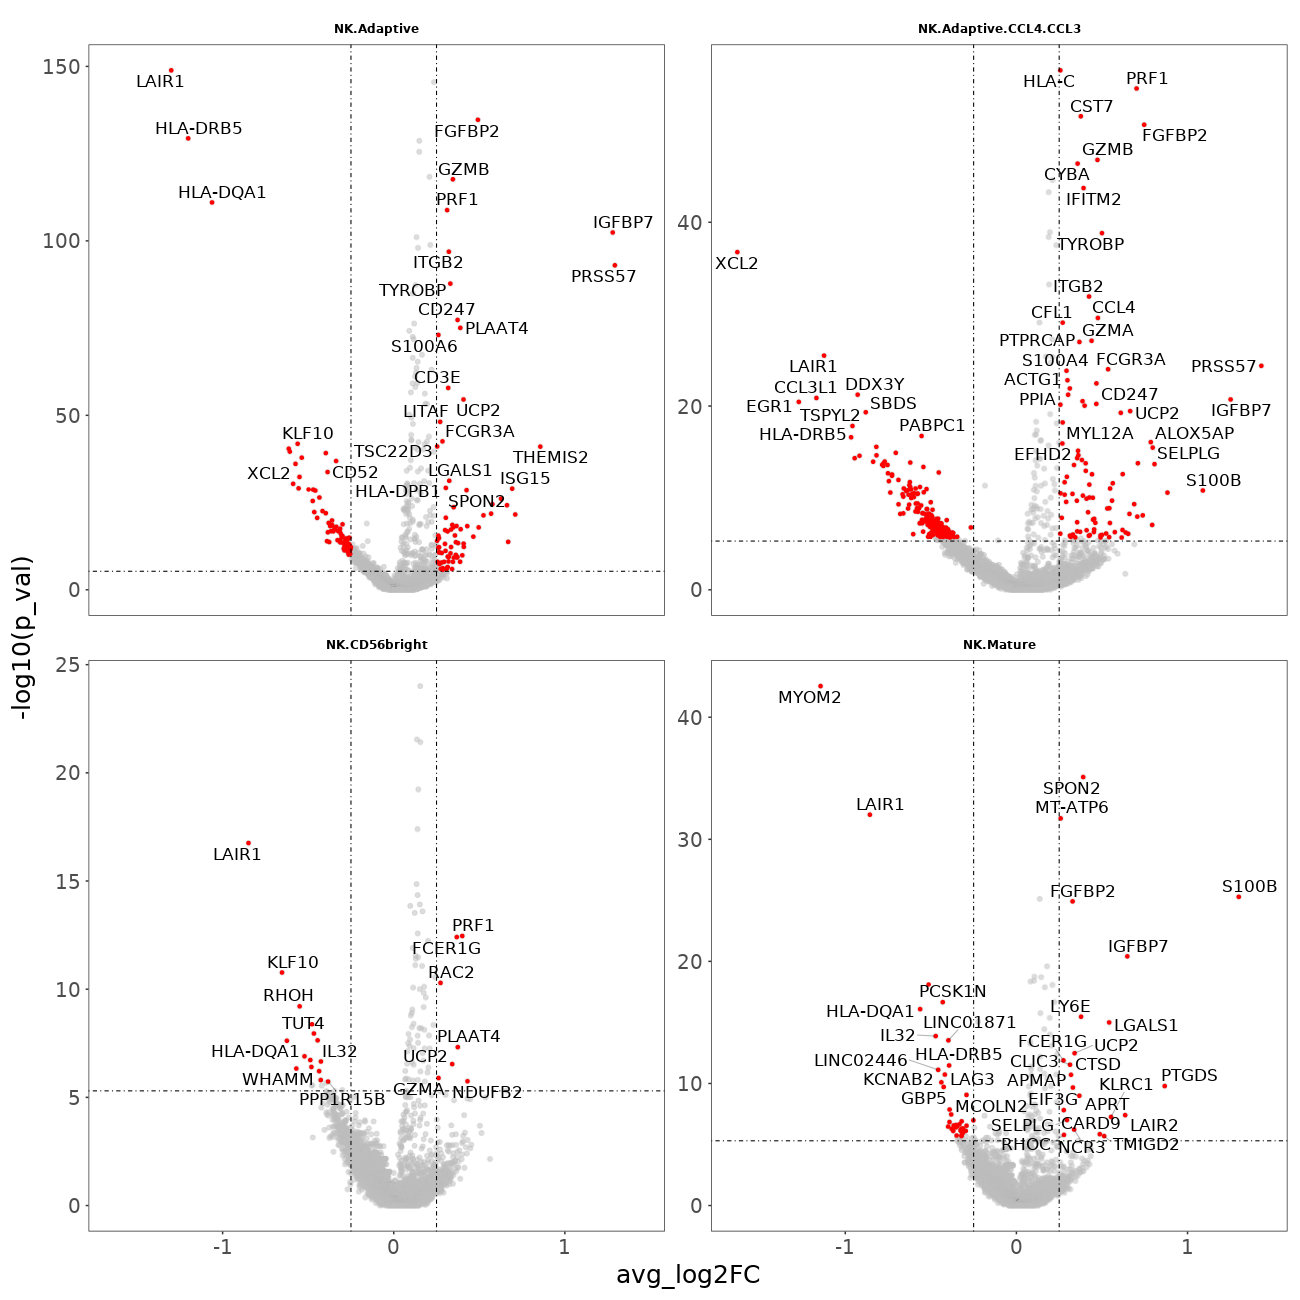

In [30]:
%%R -h 1300 -w 1300
##plotting
library(ggplot2); theme_set(theme_bw(base_size = 25)+
                              theme(strip.text = element_text(colour = 'black', face="bold",size=12), 
                                    panel.grid.major = element_blank(), 
                                    panel.grid.minor = element_blank(),
                                    panel.border = element_rect(size = 0.7),
                                    axis.ticks.length=unit(.10, "cm"),
                                    axis.ticks = element_line(size=0.7),
                                    strip.background = element_blank()))


volcano_df <- merge_degs %>%
filter(!grepl("Prolifering", annotation)) %>%
filter(grepl("HBVvsHBV_HIV", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, gene, NA))

volcanoplots_HBVvsco <- volcano_df %>%
filter(!grepl("IGLV", gene)) %>%
ggplot(aes(avg_log2FC, -log10(p_val))) +
ggrastr::rasterise(geom_point(color="gray", alpha=0.5))+
geom_point(data = volcano_df %>% filter(signif == "signif"), color = "red")+
facet_wrap(~annotation, scales="free_y")+
geom_vline(xintercept=0.25,linetype="dotdash")+
geom_vline(xintercept=-0.25,linetype="dotdash")+
geom_hline(yintercept= -log10(0.000005), linetype="dotdash")+
ggrepel::geom_text_repel(aes(label = labels),
  verbose = TRUE,
  seed = 123,
  max.time = 1,
  max.iter = Inf,
  max.overlaps = 10,
  segment.alpha	=0.3,
  size = 6
)
pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_volcano_subsets.pdf",width = 20,height = 20)
plot(volcanoplots_HBVvsco)
dev.off()

print(volcanoplots_HBVvsco)



text repel complete in 40 iterations (0.14s), 1 overlaps
0.50s elapsed for 2740 iterations, 10 overlaps. Consider increasing 'max.time'.
0.50s elapsed for 7320 iterations, 4 overlaps. Consider increasing 'max.time'.
0.50s elapsed for 870 iterations, 17 overlaps. Consider increasing 'max.time'.


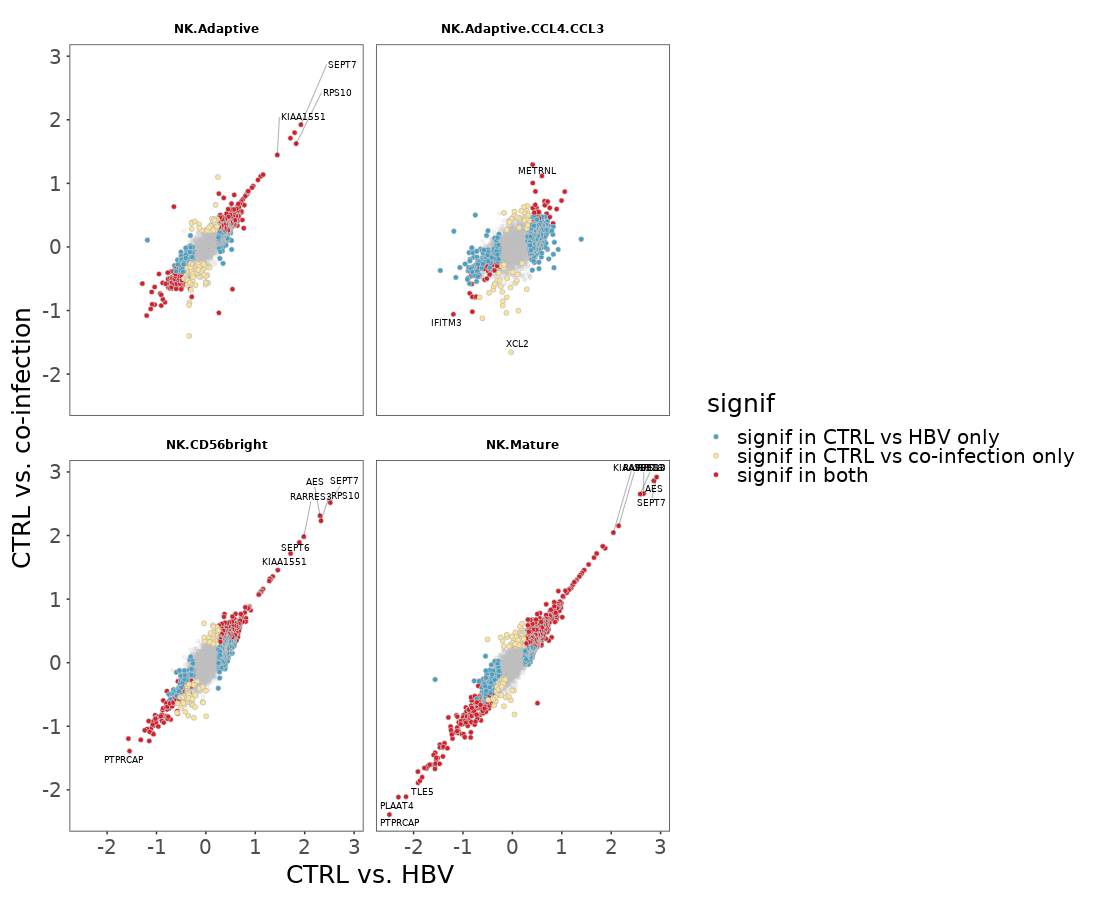

In [31]:
%%R -h 900 -w 1100

CTRL_degs <- merge_degs %>%
filter(!grepl("Prolifering", annotation)) %>%
filter(grepl("CTRL", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, gene, NA))


CTRL_degs <- split(CTRL_degs, CTRL_degs$contrast)
cross_df <- CTRL_degs[["CTRLvsHBV"]] %>%
full_join(CTRL_degs[["CTRLvsHBV_HIV"]], by=c("gene", "annotation")) %>%
mutate(signif = ifelse(signif.x == "signif" & is.na(signif.y), "signif in CTRL vs HBV only",
                            ifelse(is.na(signif.x) & signif.y == "signif", "signif in CTRL vs co-infection only", 
                                  ifelse(signif.x == "signif" & signif.y == "signif", "signif in both",NULL)))) %>%
mutate(labels = ifelse(signif.x == "signif" & is.na(signif.y), gene,
                            ifelse(is.na(signif.x) & signif.y == "signif", gene, 
                                  ifelse(signif.x == "signif" & signif.y == "signif", gene,NA))))  

cross_df %>%
ggplot(aes(avg_log2FC.x, avg_log2FC.y))+
geom_point(color = "gray", alpha=0.2)+
geom_point(data = cross_df %>% filter(!is.na(signif)), color="white")+
geom_point(data = cross_df %>% filter(!is.na(signif)), aes(fill = signif), shape = 21, color= "gray", size = 2)+
facet_wrap(~annotation)+
ggrepel::geom_text_repel(aes(label = labels),
  verbose = TRUE,
  seed = 123,
  max.time = 0.5,
  max.iter = Inf,
  max.overlaps = 5,
  segment.alpha	=0.3,
  size = 3)+
scale_fill_manual(values = c("#43a2ca", "#fee391", "#DD1C28"))+
xlab("CTRL vs. HBV")+
ylab("CTRL vs. co-infection")


In [32]:
%%R -w 1000


enrichdfdown = cross_df %>% filter(!is.na(signif)) %>% filter(avg_log2FC.x <0)

enrichdfdown_list = split(enrichdfdown, enrichdfdown$annotation)

enrich_infection <- lapply(names(enrichdfdown_list), function(x){
    data <- enrichdfdown_list[[x]]$gene
    ontology = "MsigdbC2BIOCARTA"
    eTerm <- xEnricherGenes(data=data, ontology=ontology, test = "hypergeo",min.overlap = 2)
    eTerm_im <- xEnrichConciser(eTerm)
    df <- xEnrichViewer(eTerm_im, 10, details = T)
return(df)
})



In [33]:
%%R
names(enrich_infection) <- names(enrichdfdown_list)
enrich_infection = lapply(names(enrich_infection), function(x){
    enrich_infection[[x]]$annotation <- x
    return(enrich_infection[[x]])
})
head(enrich_infection[[1]])
enrich_infection <- data.table::rbindlist(enrich_infection)


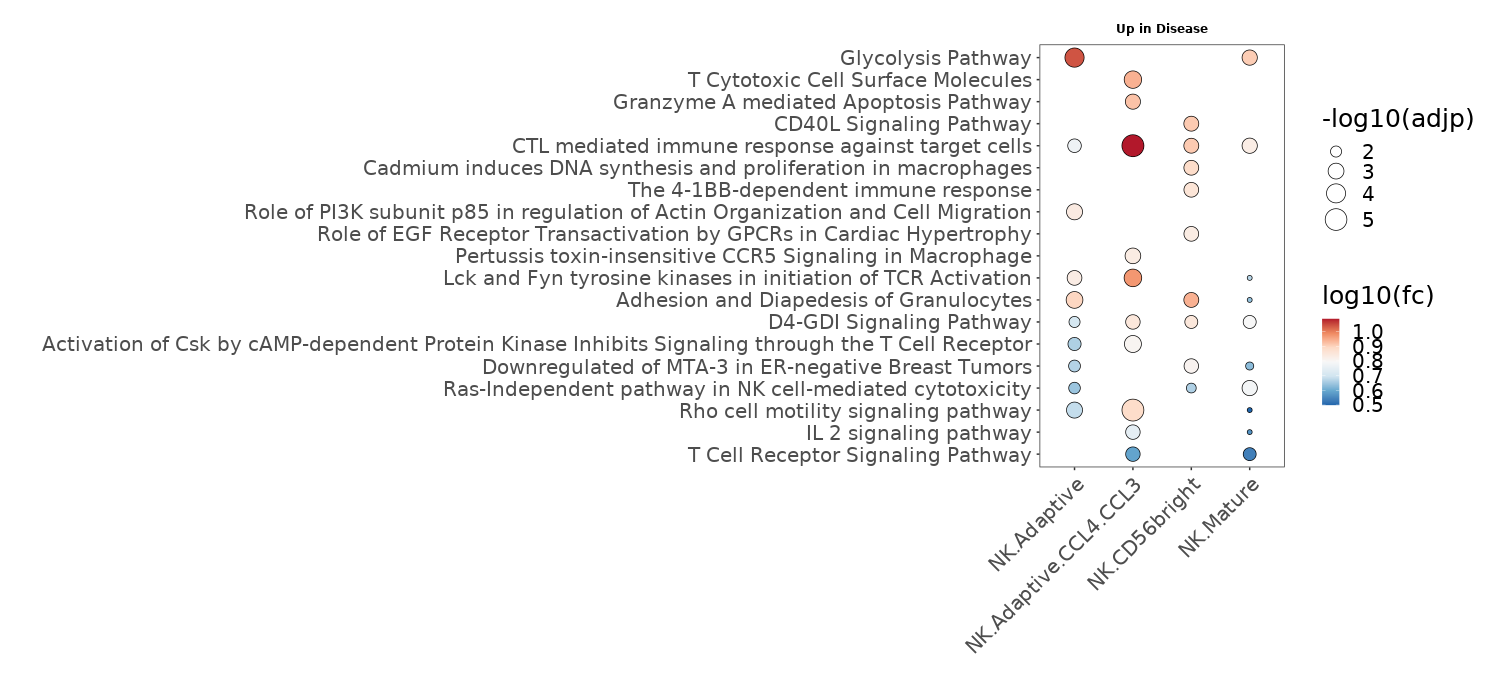

In [57]:
%%R -w 1500 -h 700
library(RColorBrewer)
enrich_infection %>%
filter(adjp <0.05) %>%
filter(nOverlap >=3) %>%
mutate(category = "Up in Disease") %>%
ggplot(aes(annotation, reorder(name, log10(fc))))+
geom_point(aes(fill = log10(fc), size = -log10(adjp)), shape = 21)+
scale_fill_distiller(palette = "RdBu")+
theme(axis.text.x = element_text(angle=45, hjust =1))+
scale_size(range = c(2, 10))+
facet_wrap(~category)+
xlab("")+
ylab("")




In [35]:
## load coding gene reference
with open("/well/immune-rep/users/vbw431/Projects/Fairfax/Mel_all/data/coding_genes_noIg.txt") as f:
    coding = f.read().splitlines() 


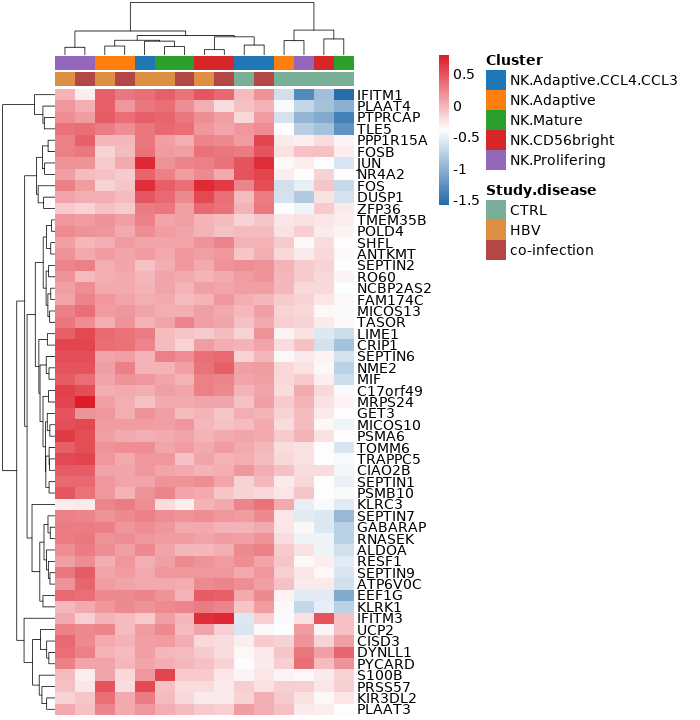

In [36]:
%%R -w 700 -h 720 -i coding
enrichdfdown2 = cross_df %>% filter(!is.na(signif))  %>% filter(avg_log2FC.x <0)

enrichdfdown_list2 = split(enrichdfdown, enrichdfdown$annotation)


genes_disease <- lapply(names(enrichdfdown_list2), function(x){
    z <- enrichdfdown_list2[[x]] %>%
        filter(p_val_adj.x <0.00005 )%>%
    filter(abs(avg_log2FC.x) >0.9 ) 
    z <- z[z$gene %in% coding, ]
    y <-z$gene
    return(y)})

avg_expression <- AverageExpression(
  peppa,
  assays = "RNA",
  features = unlist(genes_disease),
  group.by = c("celltype_consensus.l2", "study_disease"),
  slot = "scale.data",
  verbose = TRUE,
)

mat <- avg_expression[[1]]
# Data frame with column annotations.
colnames(mat) <- gsub("HBV_HIV", "co-infection", colnames(mat))

mat_col <- data.frame(`Study.disease` = gsub(".*_","", colnames(mat)), Cluster = gsub("_.*", "",  colnames(mat)))
rownames(mat_col) <- colnames(mat)


# List with colors for each annotation.

annot_colors=list(Cluster=c(NK.Adaptive.CCL4.CCL3 = "#1F77B4FF",
                           NK.Adaptive = "#FF7F0EFF",
                           NK.Mature = "#2CA02CFF",
                           NK.CD56bright = "#D62728FF", 
                           NK.Prolifering = "#9467BDFF"), 
                 `Study.disease` = c(CTRL="#79AF97FF",
                                  HBV="#DF8F44FF",
                                  `co-infection` = "#B24745FF" ))

heatmap <- pheatmap::pheatmap(
  mat               = mat,
  border_color      = NA,
  show_colnames     = FALSE,
    show_rownames     = TRUE,
    #labels_row = goi,
  annotation_col    = mat_col,
  annotation_colors = annot_colors,
  drop_levels       = TRUE,
annotation_names_col = FALSE, 
  fontsize          = 14,
    color = colorRampPalette(c("#276DAA", "white", "#DD1C28"))(100),
)

In [37]:
%%R

categories <- names(DEG_list_NK)

n_pos<-vector('double', length(categories))
n_neg<-vector('double', length(categories))
n<-vector('double', length(categories))
for(i in 1:length(categories)){
  n_pos[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC>0)))
  n_neg[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05 & DEG_list_NK[[i]]$avg_log2FC<0)))
  n[i]<-as.numeric(length(which(DEG_list_NK[[i]]$p_val_adj<0.05)))
}
min(n)

#And use these as input to the GOBP analysis 
sig_gene_induced<-list()
sig_gene_suppressed<-list()
summary_df<-list()
for(i in 1:length(categories)){
  summary_df[[i]]<-DEG_list_NK[[i]]
  summary_df[[i]]<-as.data.frame(summary_df[[i]])
  summary_df[[i]]$log10p <- -log10(summary_df[[i]]$p_val_adj)
  summary_df[[i]]$sig <- ifelse(summary_df[[i]]$p_val_adj > 0.049 | summary_df[[i]]$p_val_adj %in% NA, "no", "sig")
  summary_df[[i]]$change <- case_when(summary_df[[i]]$avg_log2FC > 0 & summary_df[[i]]$sig == "sig" ~ "Induced", 
                                      summary_df[[i]]$avg_log2FC < 0 & summary_df[[i]]$sig == "sig" ~ "Suppressed",
                                      summary_df[[i]]$sig %in% "no" ~ "None")
  summary_df[[i]]$x <- summary_df[[i]][,'avg_log2FC']
  summary_df[[i]]$y <- summary_df[[i]][,'log10p']
  summary_df[[i]]$colour <- summary_df[[i]][,'change']
  sig_gene_induced[[i]]<-summary_df[[i]] %>% filter(change == 'Induced') %>% arrange(-avg_log2FC) %>% head(n=min(n_pos))
  sig_gene_suppressed[[i]]<-summary_df[[i]] %>% filter(change == 'Suppressed') %>% arrange(avg_log2FC) %>% head(n=min(n_neg))
  summary_df[[i]]$label_2 <- ifelse(summary_df[[i]]$gene %in% c(sig_gene_induced[[i]]$gene, sig_gene_suppressed[[i]]$gene), paste(summary_df[[i]]$gene), paste(''))
}
names(summary_df)

NULL


In [38]:
%%R
#Run the REACTOME here

REACTOME_list<-list()
for(i in 1:length(categories)){
  tryCatch({
    background <- as.character(DEG_list_NK[[i]]$gene)
    induced <- sig_gene_induced[[i]]$gene
    suppressed <- sig_gene_suppressed[[i]]$gene
    
    List <- list(induced, suppressed)
    Condition <- list("overexpressed", "suppressed")
    Output <- list()
    
    ontology = "MsigdbC2REACTOME" # alternative is ontology = "REACTOME" or something like that
    for(j in seq_along(List)) {
      tryCatch({
          print(paste0("running enrichR for ", categories[i]))
        Output[[j]] <- xEnricherGenes(data = List[[j]], background = background, ontology = ontology,
                                      test = "hypergeo", min.overlap = 2)
        #Output[[j]] <- xEnrichConciser(Output[[j]])
        Output[[j]] <- xEnrichViewer(Output[[j]], top_num = 10, details = T)
        Output[[j]]$direction <- Condition[[j]]
      }, error=function(e){cat("ERROR 1 :",conditionMessage(e), "\n")})
    }
    
    REACTOME <- rbind(Output[[1]], Output[[2]])
    REACTOME <- data.frame(REACTOME)
    REACTOME$fc <-
      ifelse(REACTOME$direction %in% "suppressed",
             REACTOME$fc * (-1),
             REACTOME$fc)
    REACTOME$REACTOME <- row.names(REACTOME)
    REACTOME$REACTOME <-
      factor(REACTOME$REACTOME, levels = c(row.names(REACTOME[order(REACTOME$fc), ])))
    REACTOME <- REACTOME[REACTOME$adjp < 0.0501, ]
    REACTOME$label_adj <- case_when(REACTOME$direction %in% "overexpressed" ~ -1,
                                REACTOME$direction %in% "suppressed" ~ 1)
    
    REACTOME$category<-categories[i]
    REACTOME_list[[i]]<-REACTOME
    
  }, error=function(e){cat("ERROR 2 :",conditionMessage(e), "\n")})
} 

REACTOME<-plyr::ldply(REACTOME_list, rbind) 


#NOW WE DO BIG V SMALL EC BALLPLOT
#Here we just have to modify the REACTOME number for the duplicated pathways as those with duplicates are given a suffix of '1' by XGR

duplicated_pathways<-as.character(unlist(REACTOME %>% group_by(category) %>% add_count(name) %>% dplyr::filter(n>1) %>% ungroup() %>% dplyr::select(name) %>% unique()))
REACTOME<-REACTOME %>%  group_by(category, name) %>% dplyr::slice(which.max(nOverlap)) %>% ungroup()
#REACTOME$REACTOME<-ifelse(REACTOME$category=='HBV_HIV' & REACTOME$name %in% duplicated_pathways, str_sub(REACTOME$REACTOME, end=-2), paste(REACTOME$REACTOME))

#And modify to create a log scale, remove duplicates and colour the text in line with the data     
REACTOME$pos_FC<-sqrt(REACTOME$fc^2)
REACTOME$pos_log10FC<-log10(REACTOME$pos_FC)
REACTOME$log10FC<-ifelse(REACTOME$fc<0, REACTOME$pos_log10FC*-1, REACTOME$pos_log10FC)
REACTOME$category<-factor(REACTOME$category, levels = categories)

margin_spacer <- function(x) {
  # where x is the column in your dataset
  left_length <- nchar(levels(factor(x)))[1]
  if (left_length > 8) {
    return((left_length - 8) * 4)
  }
  else
    return(0)
}

[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Mature"
[1] "running enrichR for NK.Mature"
[1] "running enrichR for NK.CD56bright"
[1] "running enrichR for NK.CD56bright"


In [39]:
%%R
saveRDS(REACTOME, paste0(out.dir, "/REACTOME_NK.rds"))
#REACTOME <- readRDS(paste0(out.dir, "/REACTOME_NK.rds"))

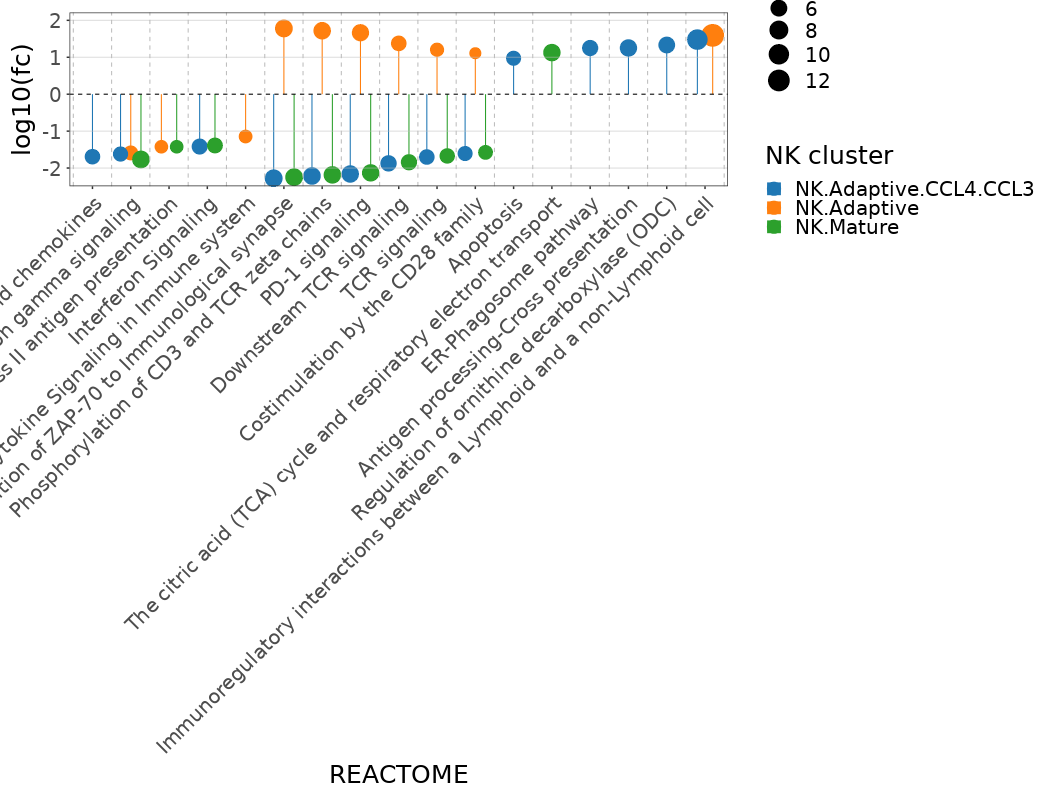

In [40]:
%%R -w 1060 -h 800
ballplot <- REACTOME %>% 
mutate(title = "HBV vs. HBV_HIV")%>%
  filter(nOverlap >=2)%>%
  filter(adjp <= 0.05)%>%
filter(!grepl("Respiratory|Activation of the mRNA|Nonsense|SRP|Sema|Peptide|UTR|43S|Vif|Metabolism of|HIV|Immune System|messenger molecules|Circadian|Translation|Influenza", name)) %>%
ggplot(aes(x=log10FC, y=reorder(name, log10FC), colour=category))+
geom_point(aes(size=-log10(pvalue)), position = position_dodge(width = .8))+
geom_errorbarh(aes(xmin = 0, xmax = log10FC),
                   height = 0,
                   position = position_dodge(width = .8))+
scale_size(range=c(5,10))+
    guides(color = guide_legend(override.aes = list(size=6)), alpha = guide_legend(override.aes = list(size=6)))+
    labs(colour='NK cluster', alpha='No. of genes in pathway')+
    #geom_line(aes(group =interaction(category, name)), size =1)+
  ggsci::scale_color_d3() +
  scale_alpha_continuous(n.breaks=4,range = c(0.4, 1))+
  ylab('REACTOME')+
  xlab('log10(fc)')+
geom_vline(lty = 2, xintercept = 0)+
geom_hline(lty = 2, yintercept=seq(from = 0.5, to = length(unique(REACTOME$name)), by = 1),color="gray", size = 0.5, alpha=1)+
geom_vline(xintercept=c(-2,-1,1,2),color="gray", size = 0.5, alpha=0.5)+
coord_flip()+
theme(axis.text.x = element_text(angle=45, hjust=1))
#facet_wrap(~category, ncol = 1, scales = "free_y")+
#scale_y_reordered()

pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_ballplot.pdf",width = 13,height = 8)
plot(ballplot)
dev.off()

print(ballplot)

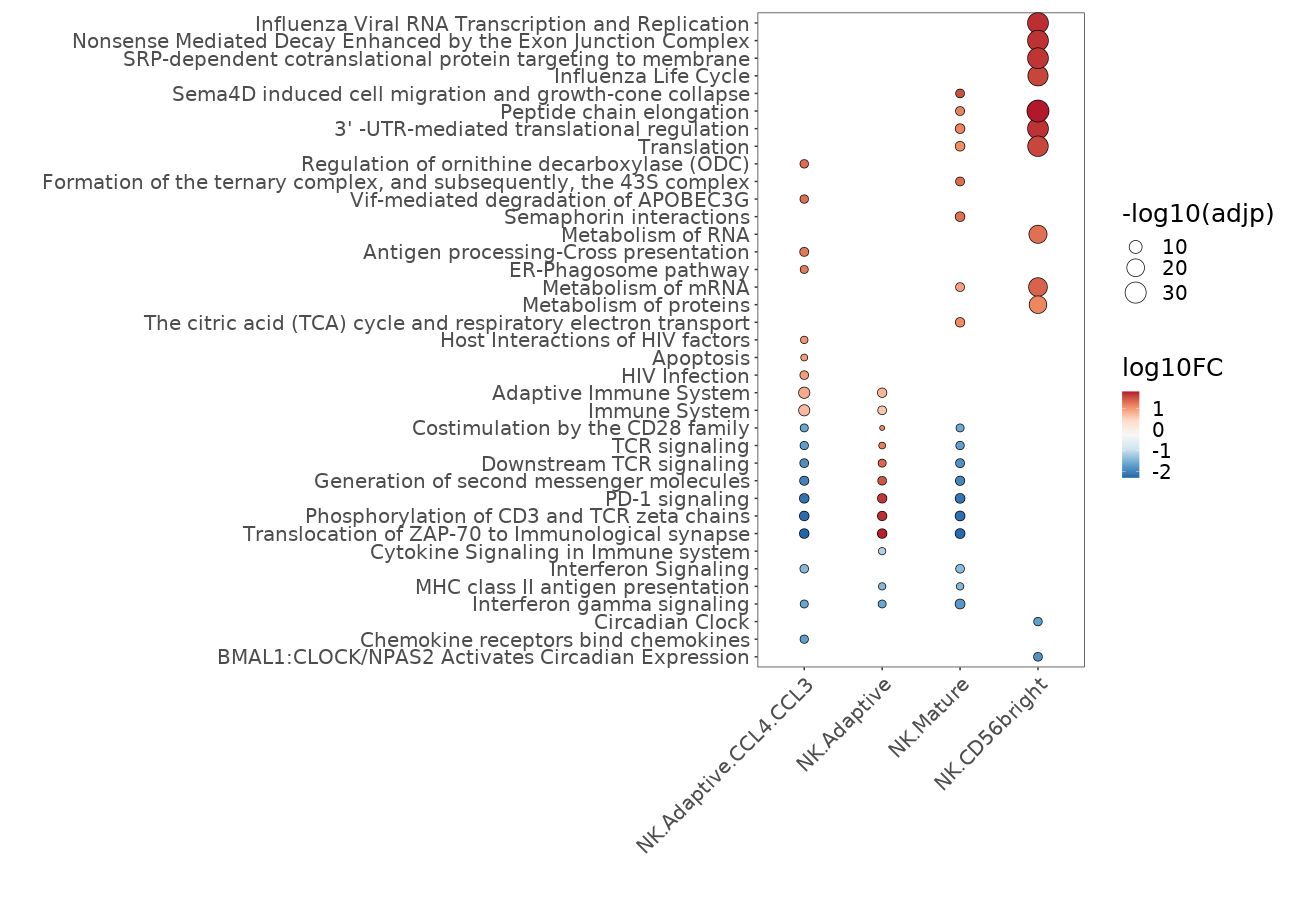

In [41]:
%%R -w 1300 -h 900
library(RColorBrewer)
REACTOME %>%
  filter(adjp <= 0.0005)%>%
filter(nOverlap >=2) %>%
filter(!grepl("Respiratory|Activation of the mRNA|Immunoregulatory", name)) %>%
ggplot(aes(category, reorder(name, log10FC)))+
geom_point(aes(fill = log10FC, size = -log10(adjp)), shape = 21)+
scale_fill_distiller(palette = "RdBu")+
theme(axis.text.x = element_text(angle=45, hjust =1))+
scale_size(range = c(2, 10))+
xlab("")+
ylab("")

In [42]:
%%R
genes_toplot_df <- REACTOME %>% as.data.frame %>% 
filter(grepl("gamma|Chemokine", name)) %>% 
select(name,members_Anno)  

splitted <- strsplit(as.character(genes_toplot_df$members_Anno), ",")

genes_toplot_long <- data.frame(name = rep.int(genes_toplot_df$name, sapply(splitted, length)), members_Anno = unlist(splitted))
genes_toplot_long$members_Anno <- gsub(" ", "", genes_toplot_long$members_Anno)

##remove duplicated genes across multiple pathways (we will take the first pathway)
genes_toplot_long <- genes_toplot_long %>%
group_by(members_Anno) %>%
dplyr::slice(1)


rownames(genes_toplot_long) <- genes_toplot_long$members_Anno

genes_toplot <- genes_toplot_long$members_Anno

head(genes_toplot_long)




# A tibble: 6 x 2
# Groups:   members_Anno [6]
  name                                members_Anno
  <chr>                               <chr>       
1 Chemokine receptors bind chemokines ACKR2       
2 Chemokine receptors bind chemokines ACKR3       
3 Chemokine receptors bind chemokines ACKR4       
4 Interferon gamma signaling          B2M         
5 Interferon gamma signaling          CAMK2A      
6 Interferon gamma signaling          CAMK2B      


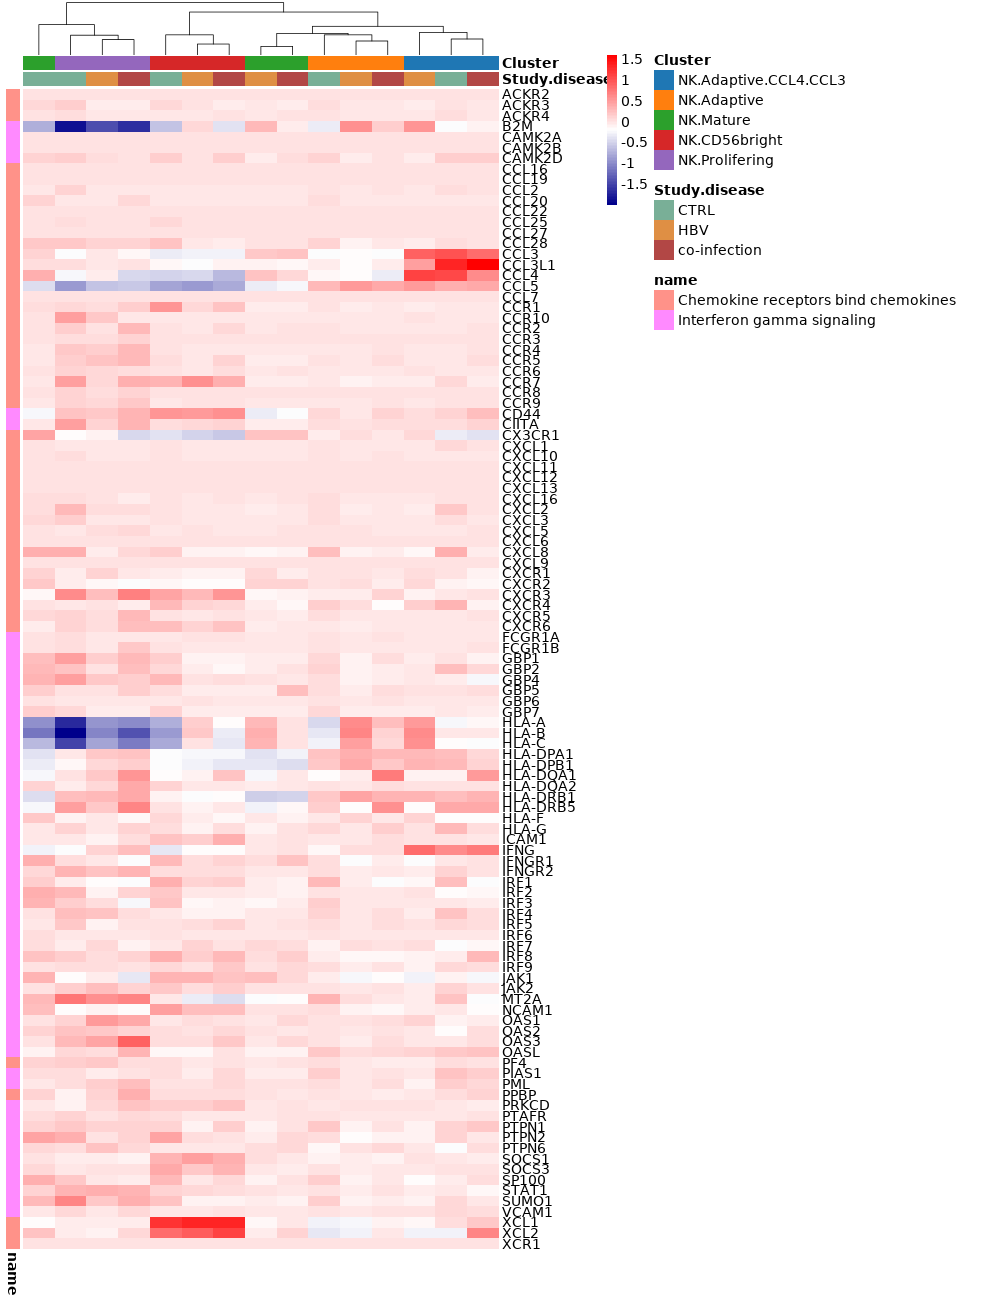

In [43]:
%%R -w 1000 -h 1300

avg_expression_reactome <- AverageExpression(
  peppa,
  assays = "RNA",
  features = unlist(genes_toplot),
  group.by = c("celltype_consensus.l2", "study_disease"),
  slot = "scale.data",
  verbose = TRUE,
)

mat_reactome <- avg_expression_reactome[[1]]
# Data frame with column annotations.
colnames(mat_reactome) <- gsub("HBV_HIV", "co-infection", colnames(mat_reactome))

mat_col_reactome <- data.frame(`Study.disease` = gsub(".*_","", colnames(mat_reactome)), Cluster = gsub("_.*", "",  colnames(mat_reactome)))
rownames(mat_col_reactome) <- colnames(mat_reactome)


# List with colors for each annotation.
#mat_colors <- list(group = brewer.pal(3, "Set1"))
#names(mat_colors$group) <- unique(col_groups)
annot_colors=list(Cluster=c(NK.Adaptive.CCL4.CCL3 = "#1F77B4FF",
                           NK.Adaptive = "#FF7F0EFF",
                           NK.Mature = "#2CA02CFF",
                           NK.CD56bright = "#D62728FF", 
                           NK.Prolifering = "#9467BDFF"), 
                 `Study.disease` = c(CTRL="#79AF97FF",
                                  HBV="#DF8F44FF",
                                  `co-infection` = "#B24745FF" ))

sub_anno <- genes_toplot_long %>% ungroup() %>% as.data.frame()
rownames(sub_anno) <- sub_anno$members_Anno
head(sub_anno)
# 1) reorder the matrix based in the annotation
mat_reactome_ordered <- mat_reactome[rownames(sub_anno), ]

# 2) plot heatmap with no row clusters

heatmap_reactome <- pheatmap::pheatmap(
  mat               = mat_reactome_ordered,
  border_color      = NA,
  show_colnames     = FALSE,
    show_rownames     = T,
    #labels_row = goi,
    annotation_row = sub_anno%>%dplyr::select(-members_Anno),
  annotation_col    = mat_col_reactome,
  annotation_colors = annot_colors,
  drop_levels       = TRUE,
annotation_names_col = TRUE, 
  fontsize          = 14,
    cluster_rows = FALSE,
    color = colorRampPalette(c("Darkblue", "white","red"))(100),
)


In [44]:
%%R
sub_anno <- structure(list(seq_share = c("shared", "shared", "shared", "shared", 
"shared", "shared", "unshared", "unshared", "unshared", "unshared", 
"unshared", "unshared", "unshared", "unshared", "unshared", "unshared", 
"unshared", "unshared", "unshared", "unshared")), .Names = "seq_share", row.names = c("XPRHQTYE", 
"GQQG", "GYNY", "QLDY", "RGQI", "SRLPSDX", "PAVS", "PEAH", "RXVQYGTDT", 
"RAPM", "SXPGTGKSA", "SLXVAGTNEK", "SLQGGXT", "SLTXASVE", "SPRXVTE", 
"SPSARDRVGX", "SPTGGSYNX", "SRXGTSGRADE", "SRDXGPNYG", "TGTXLE"
), class = "data.frame")






In [45]:
%%R
#Run the GOBP here

PATHWAY_list<-list()
for(i in 1:length(categories)){
  tryCatch({
    background <- as.character(DEG_list_NK[[i]]$gene)
    induced <- sig_gene_induced[[i]]$gene
    suppressed <- sig_gene_suppressed[[i]]$gene
    
    List <- list(induced, suppressed)
    Condition <- list("overexpressed", "suppressed")
    Output <- list()
    
    ontology = "GOBP" # alternative is ontology = "PATHWAY" or something like that
    for(j in seq_along(List)) {
      tryCatch({
          print(paste0("running enrichR for ", categories[i]))
        Output[[j]] <- xEnricherGenes(data = List[[j]], background = background, ontology = ontology,
                                      ontology.algorithm = ifelse(ontology == "GOBP", "lea", "none"),
                                      test = "hypergeo", min.overlap = 2)
        Output[[j]] <- xEnrichConciser(Output[[j]])
        Output[[j]] <- xEnrichViewer(Output[[j]], top_num = 20)
        Output[[j]]$direction <- Condition[[j]]
      }, error=function(e){cat("ERROR 1 :",conditionMessage(e), "\n")})
    }
    
    PATHWAY <- rbind(Output[[1]], Output[[2]])
    PATHWAY <- data.frame(PATHWAY)
    PATHWAY$fc <-
      ifelse(PATHWAY$direction %in% "suppressed",
             PATHWAY$fc * (-1),
             PATHWAY$fc)
    PATHWAY$PATHWAY <- row.names(PATHWAY)
    PATHWAY$PATHWAY <-
      factor(PATHWAY$PATHWAY, levels = c(row.names(PATHWAY[order(PATHWAY$fc), ])))
    PATHWAY <- PATHWAY[PATHWAY$adjp < 0.0501, ]
    PATHWAY$label_adj <- case_when(PATHWAY$direction %in% "overexpressed" ~ -1,
                                PATHWAY$direction %in% "suppressed" ~ 1)
    
    PATHWAY$category<-categories[i]
    PATHWAY_list[[i]]<-PATHWAY
    
  }, error=function(e){cat("ERROR 2 :",conditionMessage(e), "\n")})
} 

PATHWAY<-plyr::ldply(PATHWAY_list, rbind) 


#NOW WE DO BIG V SMALL EC BALLPLOT
#Here we just have to modify the PATHWAY number for the duplicated pathways as those with duplicates are given a suffix of '1' by XGR

duplicated_pathways<-as.character(unlist(PATHWAY %>% group_by(category) %>% add_count(name) %>% dplyr::filter(n>1) %>% ungroup() %>% dplyr::select(name) %>% unique()))
PATHWAY<-PATHWAY %>%  group_by(category, name) %>% dplyr::slice(which.max(nOverlap)) %>% ungroup()
PATHWAY$PATHWAY<-ifelse(PATHWAY$category=='HBV_HIV' & PATHWAY$name %in% duplicated_pathways, str_sub(PATHWAY$PATHWAY, end=-2), paste(PATHWAY$PATHWAY))

#And modify to create a log scale, remove duplicates and colour the text in line with the data     
PATHWAY$pos_FC<-sqrt(PATHWAY$fc^2)
PATHWAY$pos_log10FC<-log10(PATHWAY$pos_FC)
PATHWAY$log10FC<-ifelse(PATHWAY$fc<0, PATHWAY$pos_log10FC*-1, PATHWAY$pos_log10FC)
PATHWAY$category<-factor(PATHWAY$category, levels = categories)


margin_spacer <- function(x) {
  # where x is the column in your dataset
  left_length <- nchar(levels(factor(x)))[1]
  if (left_length > 8) {
    return((left_length - 8) * 4)
  }
  else
    return(0)
}

[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive.CCL4.CCL3"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Adaptive"
[1] "running enrichR for NK.Mature"
[1] "running enrichR for NK.Mature"
[1] "running enrichR for NK.CD56bright"
[1] "running enrichR for NK.CD56bright"


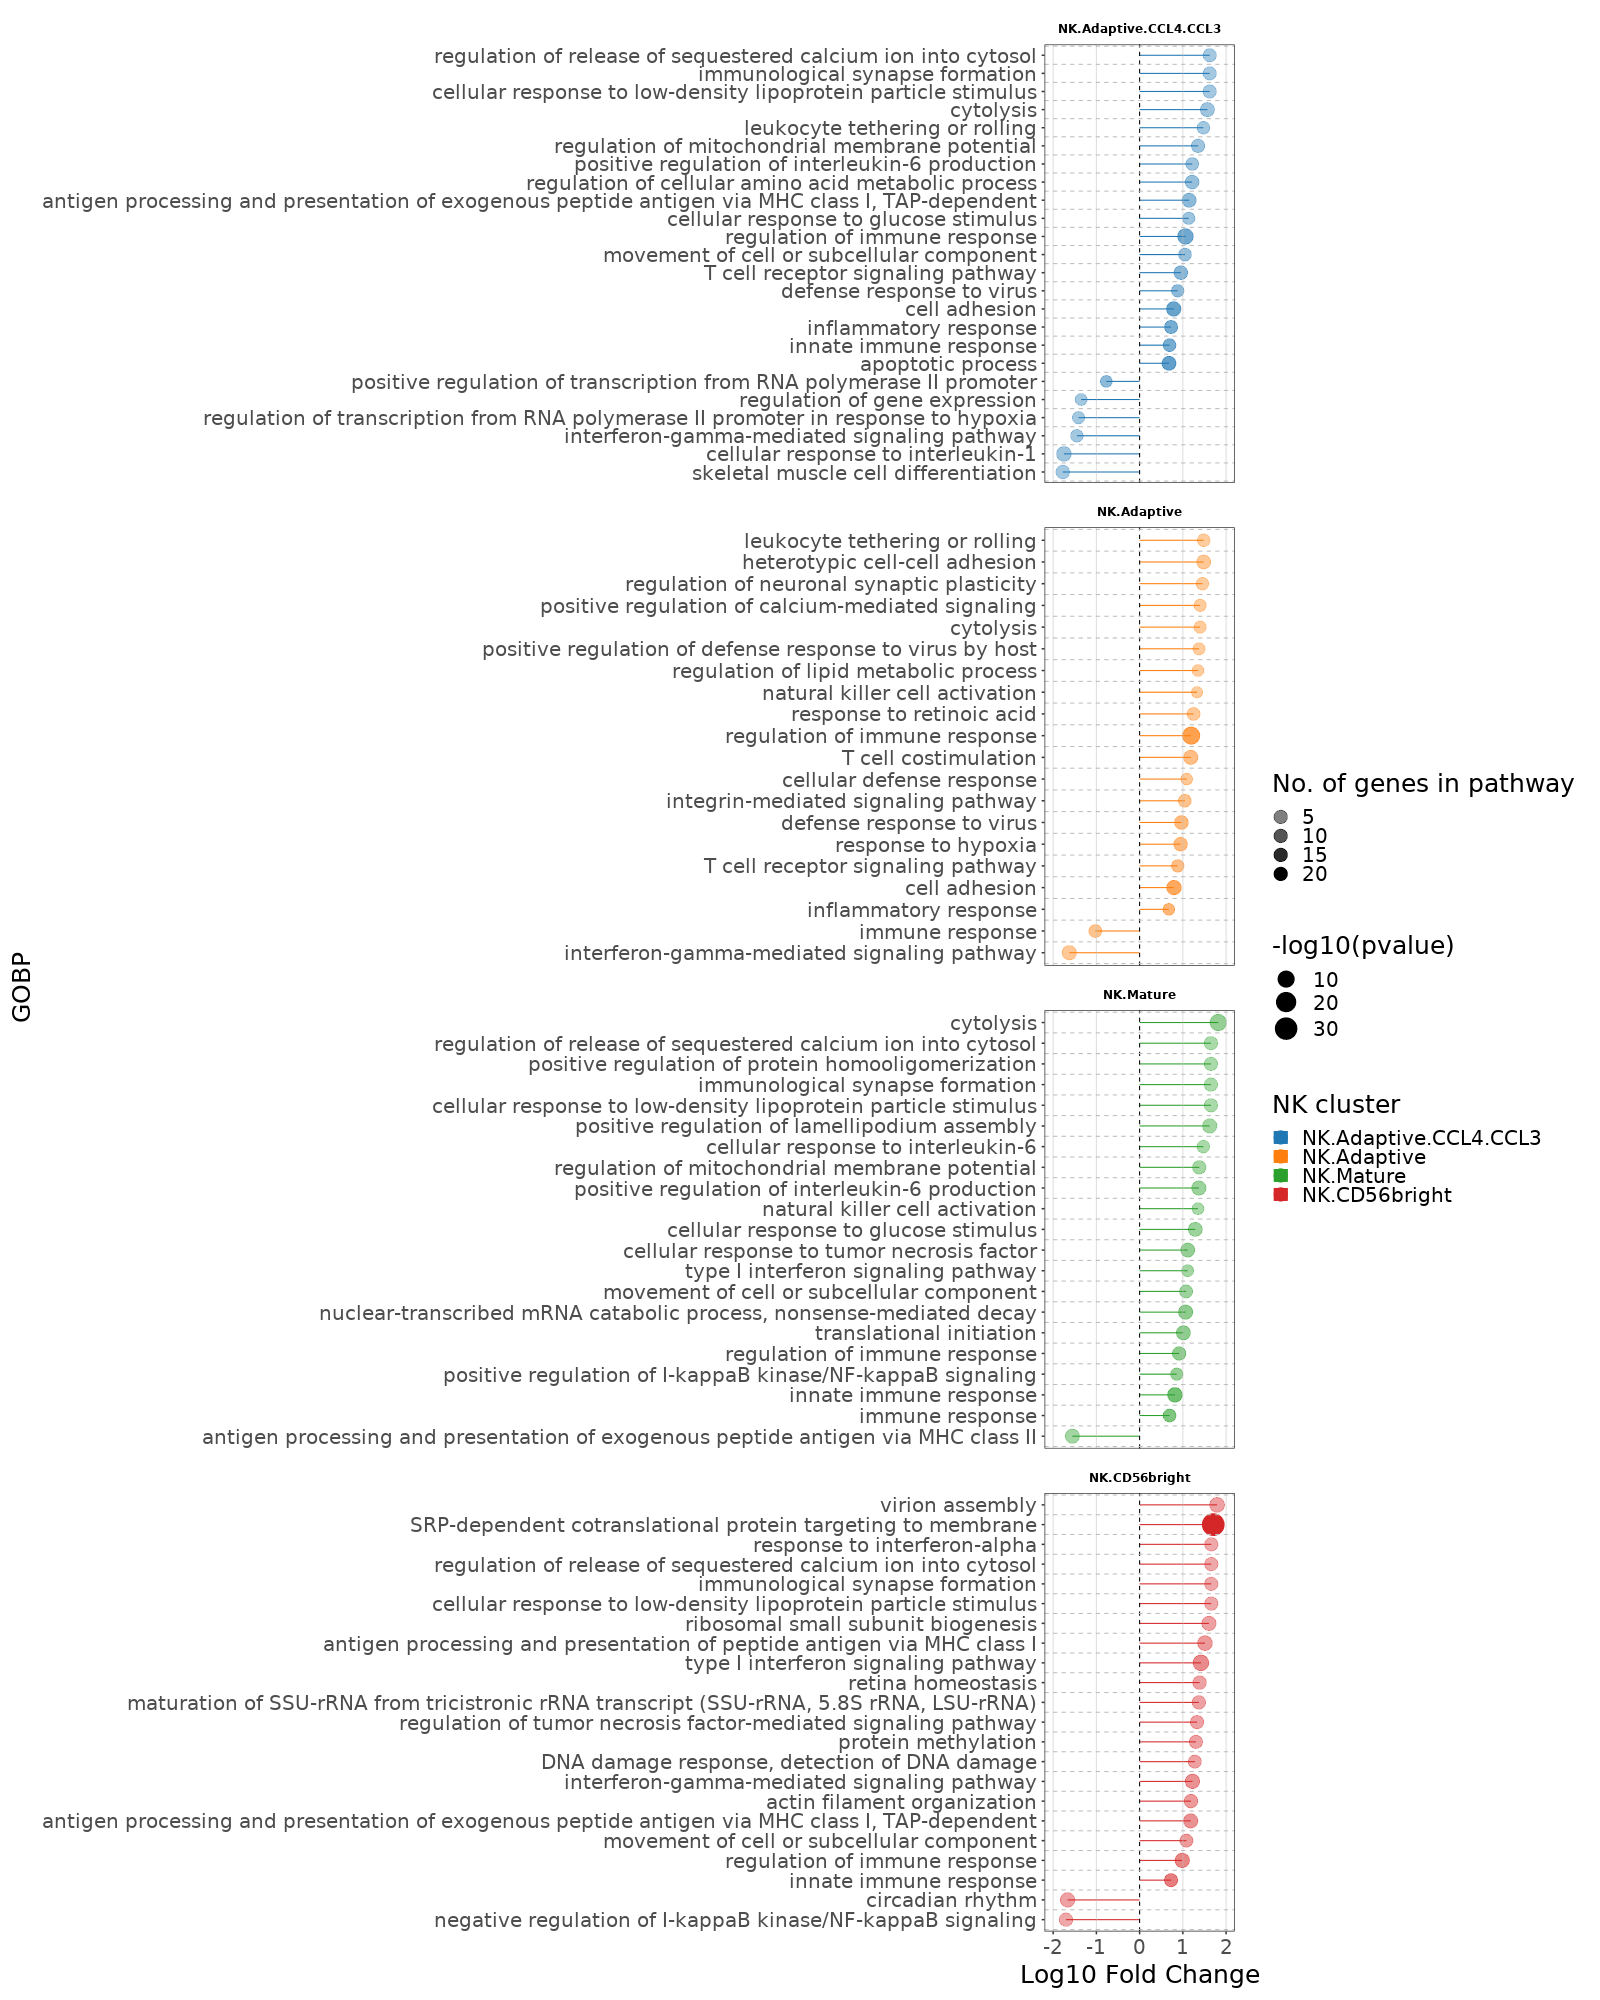

In [46]:
%%R -w 1600 -h 2000
library(tidytext)
ballplot2 <- PATHWAY %>% 
mutate(title = "HBV vs. HBV_HIV")%>%
  filter(nOverlap >=2)%>%
  filter(adjp <= 0.0005)%>%
ggplot(aes(x=log10FC, y=reorder_within(name, log10FC, category), colour=category))+
geom_point(aes(size=-log10(pvalue),alpha=nOverlap), position = position_dodge(width = .8))+
geom_errorbarh(aes(xmin = 0, xmax = log10FC),
                   height = 0,
                   position = position_dodge(width = .8))+
scale_size(range=c(5,10))+
    guides(color = guide_legend(override.aes = list(size=6)), alpha = guide_legend(override.aes = list(size=6)))+
    labs(colour='NK cluster', alpha='No. of genes in pathway')+
    geom_line(aes(group =interaction(category, name)), size =1)+
  ggsci::scale_color_d3() +
  scale_alpha_continuous(n.breaks=4,range = c(0.4, 1))+
  ylab('GOBP')+
  xlab('Log10 Fold Change')+
geom_vline(lty = 2, xintercept = 0)+
geom_hline(lty = 2, yintercept=seq(from = 0.5, to = length(unique(PATHWAY$name)), by = 1),color="gray", size = 0.5, alpha=1)+
geom_vline(xintercept=c(-2,-1,1,2),color="gray", size = 0.5, alpha=0.5)+
facet_wrap(~category, ncol = 1, scales = "free_y")+
scale_y_reordered()


print(ballplot2)

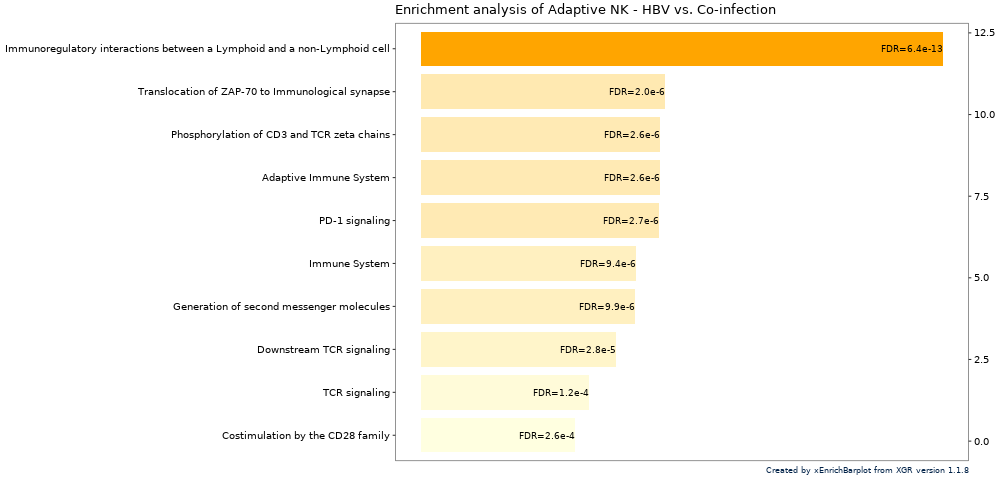

In [47]:
%%R -w 1000
##enriched pathways in HBV Adaptive
bp <- xEnrichBarplot(REACTOME %>% filter(grepl("Adaptive$", category)) %>% filter(grepl("overexpress", direction)), top_num='auto', displayBy="fdr")
bp + ggtitle("Enrichment analysis of Adaptive NK - HBV vs. Co-infection")

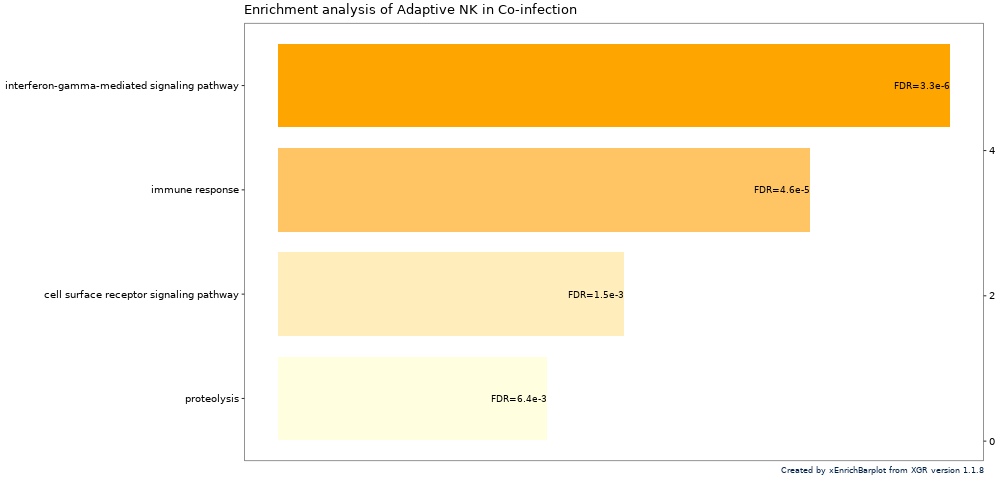

In [48]:
%%R -w 1000
##enriched pathways in Co-infection Adaptive
bp <- xEnrichBarplot(PATHWAY %>% filter(grepl("Adaptive$", category)) %>% filter(grepl("suppress", direction)), top_num='auto', displayBy="fdr")
bp + ggtitle("Enrichment analysis of Adaptive NK in Co-infection")

## Pathway activitity analysis with progeny


In [49]:
%%R
library(progeny)

## We compute the Progeny activity scores and add them to our Seurat object
## as a new assay called Progeny. 
peppa <- progeny(peppa, scale=FALSE, organism="Human", top=500, perm=1, 
    return_assay = TRUE)


In [50]:
%%R
## We can now directly apply Seurat functions in our Progeny scores. 
## For instance, we scale the pathway activity scores. 
peppa <- Seurat::ScaleData(peppa, assay = "progeny") 

## We transform Progeny scores into a data frame to better handling the results
progeny_scores_df <- 
    as.data.frame(t(GetAssayData(peppa, slot = "scale.data", 
        assay = "progeny"))) %>%
    rownames_to_column("Cell") %>%
    gather(Pathway, Activity, -Cell) 



In [51]:
%%R

progeny_scores_df <- progeny_scores_df %>% 
left_join(peppa@meta.data %>% 
          mutate(Cell = rownames(.)) 
          %>% select(celltype_consensus.l2, study_disease, Cell), by=c("Cell"))

## We summarize the Progeny scores by cellpopulation
summarized_progeny_scores <- progeny_scores_df %>% 
    group_by(Pathway, celltype_consensus.l2, study_disease) %>%
    summarise(avg = mean(Activity), std = sd(Activity))


`summarise()` has grouped output by 'Pathway', 'celltype_consensus.l2'. You can override using the `.groups` argument.


In [52]:
%%R
## prepare the data for the plot
summarized_progeny_scores_df <- summarized_progeny_scores %>%
    dplyr:::mutate(study_disease =ifelse(grepl("HBV_HIV", study_disease), "Co-infection", study_disease)) %>%
    mutate(annotation = paste0(celltype_consensus.l2, "_", study_disease)) %>%
ungroup() %>%
    dplyr::select(-std, -study_disease, -celltype_consensus.l2) %>%   
    spread(Pathway, avg) %>%
    data.frame(row.names = 1, check.names = FALSE, stringsAsFactors = FALSE) 


In [53]:
%%R
## Set colors for plot
mat_col <- data.frame(`Study.disease` = gsub(".*_","", rownames(summarized_progeny_scores_df)), Cluster = gsub("_.*", "",  rownames(summarized_progeny_scores_df)))
rownames(mat_col) <- rownames(summarized_progeny_scores_df)
print(mat_col)

annot_colors=list(Cluster=c(NK.Adaptive.CCL4.CCL3 = "#1F77B4FF",
                           NK.Adaptive = "#FF7F0EFF",
                           NK.Mature = "#2CA02CFF",
                           NK.CD56bright = "#D62728FF", 
                           NK.Prolifering = "#9467BDFF"), 
                 `Study.disease` = c(CTRL="#79AF97FF",
                                  HBV="#DF8F44FF",
                                  `Co-infection` = "#B24745FF" ))




                                   Study.disease               Cluster
NK.Adaptive.CCL4.CCL3_CTRL                  CTRL NK.Adaptive.CCL4.CCL3
NK.Adaptive.CCL4.CCL3_Co-infection  Co-infection NK.Adaptive.CCL4.CCL3
NK.Adaptive.CCL4.CCL3_HBV                    HBV NK.Adaptive.CCL4.CCL3
NK.Adaptive_CTRL                            CTRL           NK.Adaptive
NK.Adaptive_Co-infection            Co-infection           NK.Adaptive
NK.Adaptive_HBV                              HBV           NK.Adaptive
NK.CD56bright_CTRL                          CTRL         NK.CD56bright
NK.CD56bright_Co-infection          Co-infection         NK.CD56bright
NK.CD56bright_HBV                            HBV         NK.CD56bright
NK.Mature_CTRL                              CTRL             NK.Mature
NK.Mature_Co-infection              Co-infection             NK.Mature
NK.Mature_HBV                                HBV             NK.Mature
NK.Prolifering_CTRL                         CTRL        NK.Prolifering
NK.Pro

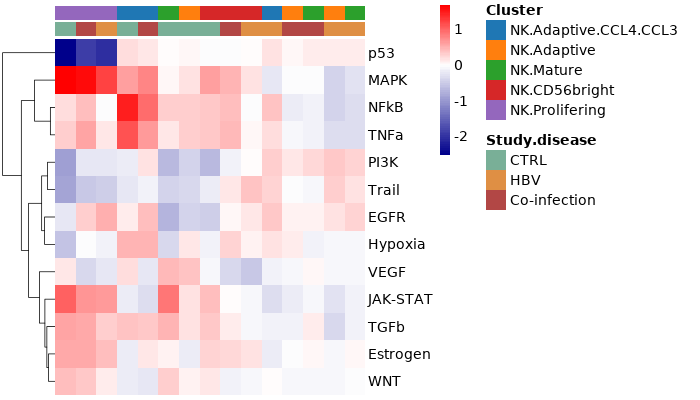

In [54]:
%%R -w 700 -h 400

##progeny heatmap
library(pheatmap)
paletteLength = 100
prog_color = colorRampPalette(c("Darkblue", "white","red"))(paletteLength)


progenyBreaks = c(seq(min(summarized_progeny_scores_df), 0, 
                      length.out=ceiling(paletteLength/2) + 1),
                  seq(max(summarized_progeny_scores_df)/paletteLength, 
                      max(summarized_progeny_scores_df), 
                      length.out=floor(paletteLength/2)))

progeny_hmap = pheatmap(t(summarized_progeny_scores_df[,-1]),fontsize=14, 
                        color=prog_color, breaks = progenyBreaks, angle_col = 45,
                        treeheight_col = 0,  border_color = NA,
                        annotation_col    = mat_col,
                        annotation_colors = annot_colors,
                        show_colnames     = FALSE,
                        annotation_names_col = FALSE
                       )

##Here we can see that the CTRL Adaptive NK

## Plot genes of interest on volcano as requested

text repel complete in 223 iterations (0.00s), 1 overlaps
text repel complete in 436 iterations (0.00s), 3 overlaps
text repel complete in 463 iterations (0.00s), 3 overlaps
text repel complete in 633 iterations (0.00s), 4 overlaps
text repel complete in 16955 iterations (0.03s), 4 overlaps
text repel complete in 4210 iterations (0.01s), 5 overlaps
text repel complete in 2479 iterations (0.00s), 6 overlaps
text repel complete in 14898 iterations (0.02s), 5 overlaps


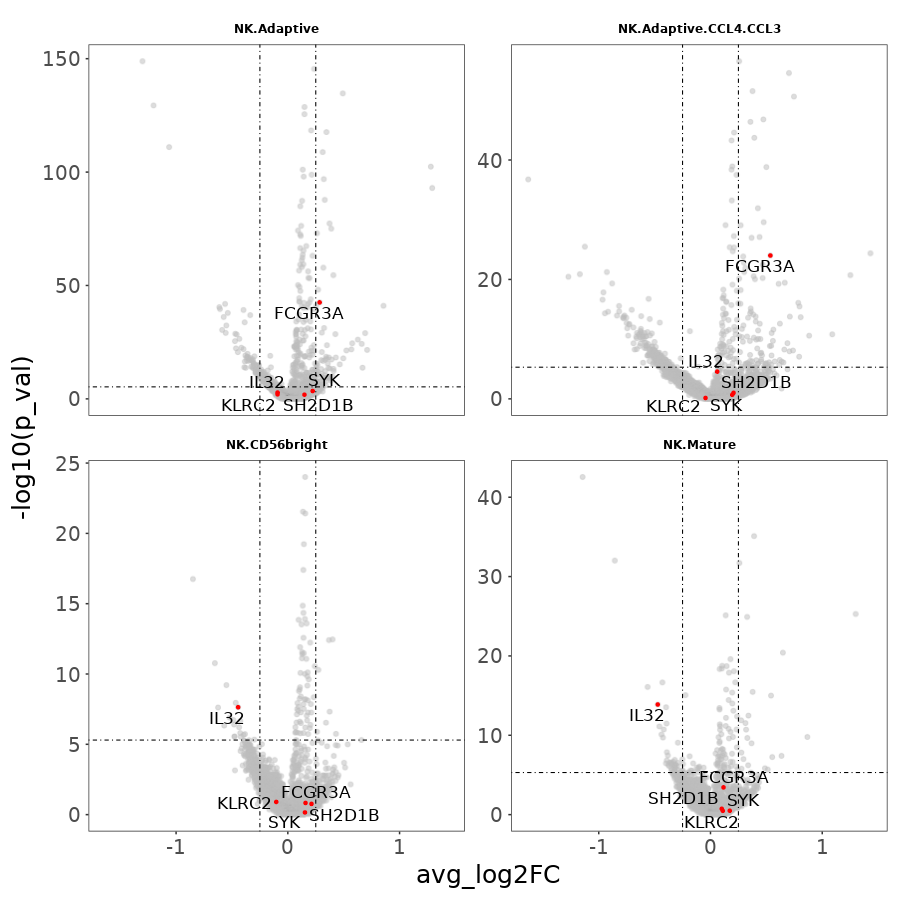

In [55]:
%%R -h 900 -w 900


volcano_df_genepanel <- merge_degs %>%
filter(!grepl("Prolifering", annotation)) %>%
filter(grepl("HBVvsHBV_HIV", contrast)) %>%
mutate(signif =ifelse(p_val_adj < 0.05 & abs(avg_log2FC) > 0.25, "signif", NA))%>%
mutate(labels =ifelse(grepl("KLRC2|FCGR3A|SYK|SH2D1B|IL32", gene), gene, NA))




volcanoplots_genepanel <- volcano_df_genepanel %>%
filter(!grepl("IGLV", gene)) %>%
ggplot(aes(avg_log2FC, -log10(p_val))) +
ggrastr::rasterise(geom_point(color="gray", alpha=0.5))+
geom_point(data = volcano_df_genepanel %>% filter(!is.na(labels)), color = "red")+
facet_wrap(~annotation, scales="free_y")+
geom_vline(xintercept=0.25,linetype="dotdash")+
geom_vline(xintercept=-0.25,linetype="dotdash")+
geom_hline(yintercept= -log10(0.000005), linetype="dotdash")+
ggrepel::geom_text_repel(aes(label = labels),
  verbose = TRUE,
  seed = 123,
  max.time = 1,
  max.iter = Inf,
  max.overlaps = 10,
  segment.alpha	=0.3,
  size = 6
)
pdf(file = "/well/immune-rep/users/vbw431/Projects/Peppa/new_out/final_plots/NK_volcano_genesets_dimitra.pdf",width = 20,height = 20)
plot(volcanoplots_genepanel)
dev.off()

print(volcanoplots_genepanel)



In [56]:
%%R
#merge_degs ## long format DEGs
#enrich_infection ## dataframe for co-differential genes of HBV and Coinfection vs ctrl
#REACTOME ## reactome analysis of HBV vs co infection
#PATHWAY ## GOBP analysis of HBV vs co infection
#summarized_progeny_scores_df ## Summarised progeny scores

## Export all dataframes to csv
write.csv(merge_degs, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/DEseq2_allcontrasts_longformat.csv")
write.csv(enrich_infection, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/DEseq2_co_differentially_expressed_infection.csv")
write.csv(PATHWAY, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/XGR_REACTOME_NKsubsets_HBVvsCo.csv")
write.csv(PATHWAY, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/XGR_GOBP_NKsubsets_HBVvsCo.csv")
write.csv(summarized_progeny_scores_df, "/well/immune-rep/users/vbw431/Projects/Peppa/new_analysis/data/DGE/Progeny_NK_study_groups.csv")







In [119]:
%%R

tmp <- peppa@meta.data %>% 
    mutate(bio_replicate = gsub("_", ".", bio_replicate)) %>%
    mutate(study_disease = gsub("_", ".", study_disease)) %>%
    mutate(Treatment_status = gsub("_", ".", Treatment_status))

peppa_test <- peppa
peppa_test@meta.data <- tmp

##check where LAIR1 is coming from
Lair <- Seurat::AverageExpression(
  peppa_test,
  assays = "RNA",
  features = "LAIR1",
  group.by = c("celltype_consensus.l2", "bio_replicate","study_disease","Treatment_status"),
  slot = "data",
  verbose = TRUE,
)

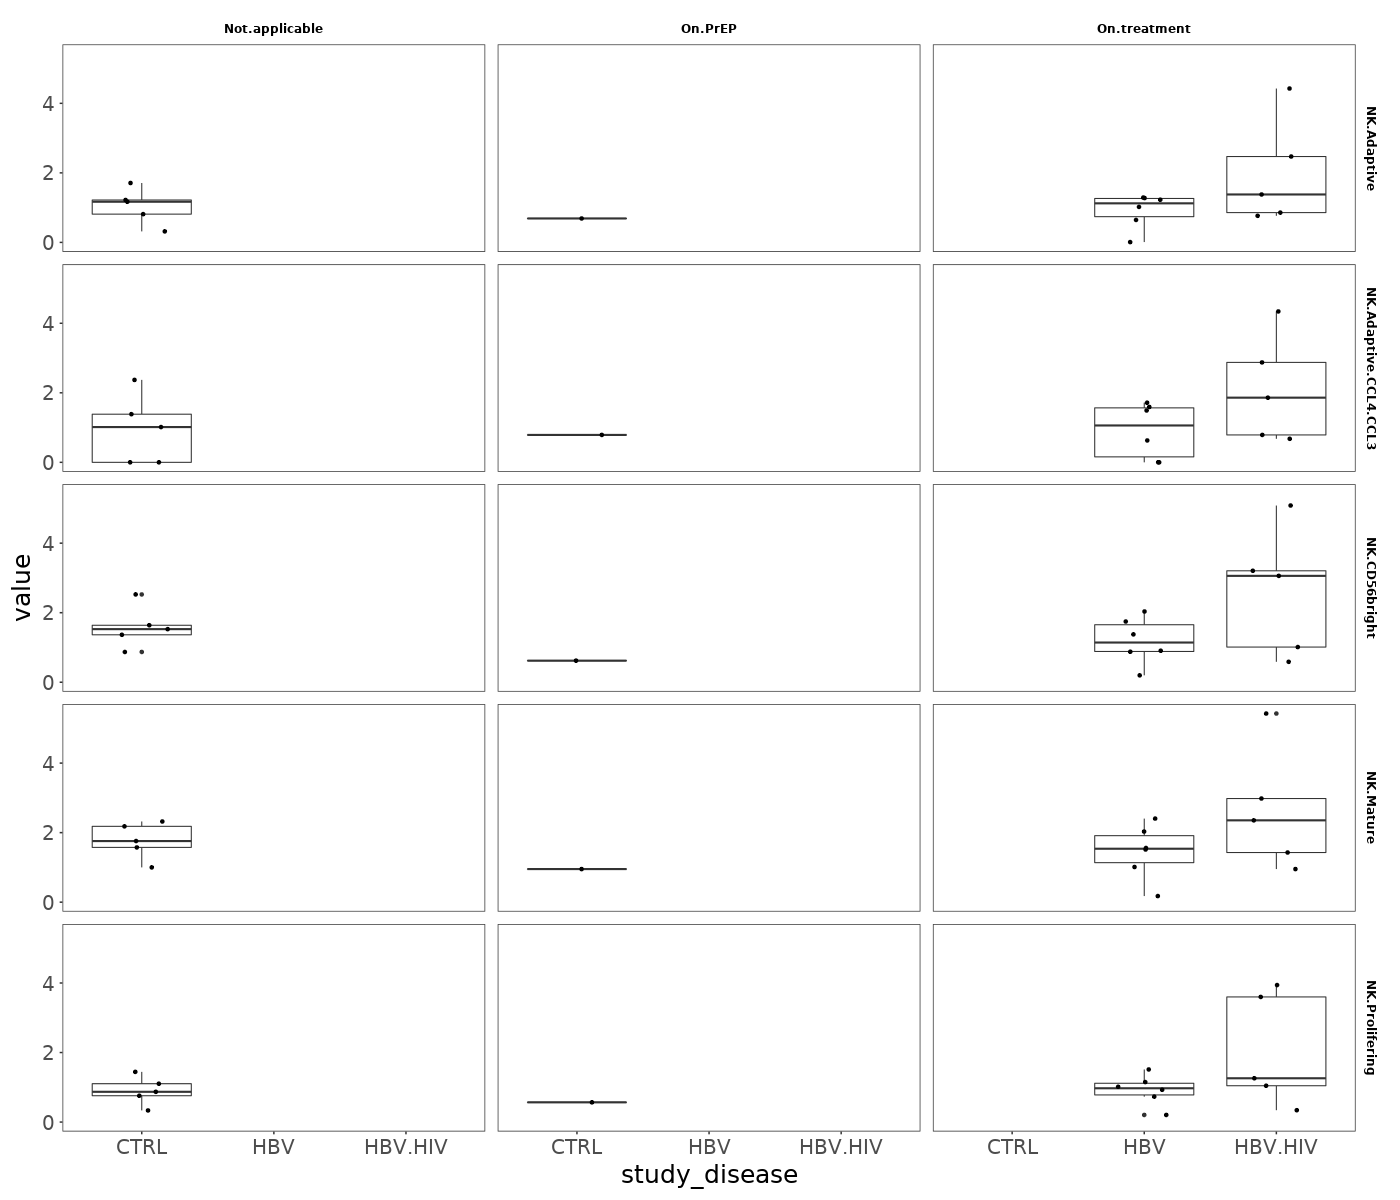

In [126]:
%%R -w 1400 -h 1200
Lair[[1]] %>%
reshape2::melt() %>%
separate(Var2, c("celltype_consensus.l2", "bio_replicate", "study_disease", "Treatment_status"), sep = "_") %>%

ggplot(aes(study_disease, value))+
geom_boxplot()+
geom_jitter(width = 0.2)+
facet_grid(vars(celltype_consensus.l2), vars(Treatment_status))



